[*********************100%%**********************]  1 of 1 completed
<ipython-input-7-495fae5e08ff>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SMA_20'] = data['Close'].rolling(window=20).mean()
<ipython-input-7-495fae5e08ff>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SMA_50'] = data['Close'].rolling(window=50).mean()
<ipython-input-7-495fae5e08ff>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Epoch 1/50
16/16 [==============================] - 6s 150ms/step - loss: 0.0640 - val_loss: 0.0078
Epoch 2/50
16/16 [==============================] - 1s 94ms/step - loss: 0.0128 - val_loss: 0.0047
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.0072 - val_loss: 0.0044
Epoch 4/50
16/16 [==============================] - 2s 149ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 5/50
16/16 [==============================] - 2s 111ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 6/50
16/16 [==============================] - 1s 93ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 7/50
16/16 [==============================] - 1s 93ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 8/50
16/16 [==============================] - 1s 94ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 9/50
16/16 [==============================] - 2s 96ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 10/50
16/16 [==============================] - 1s 93ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch

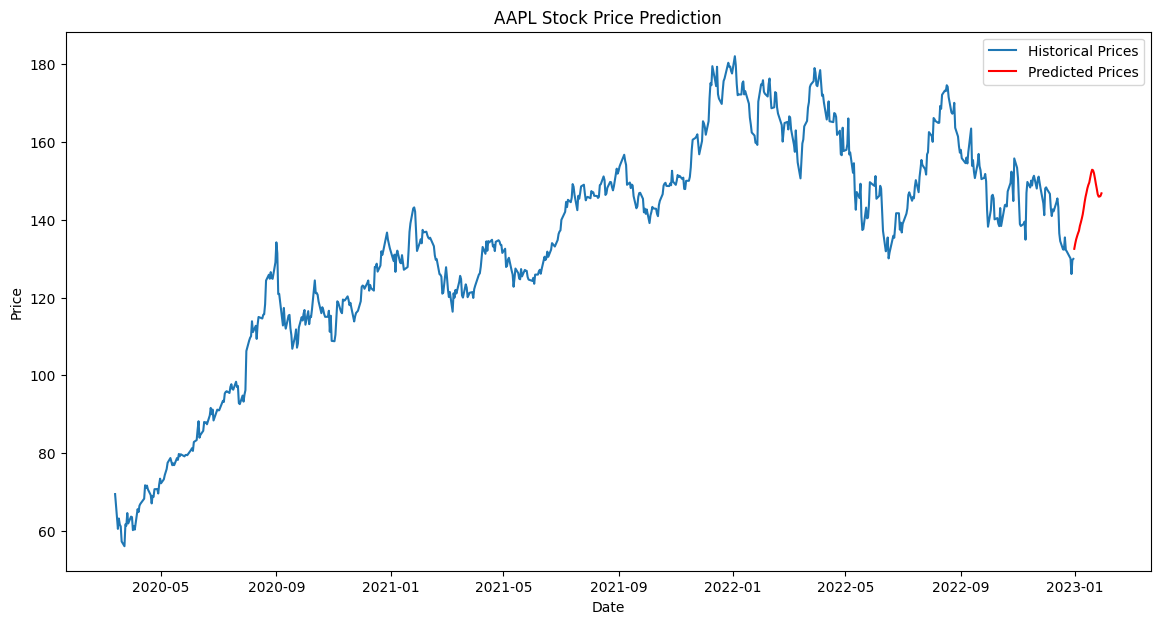

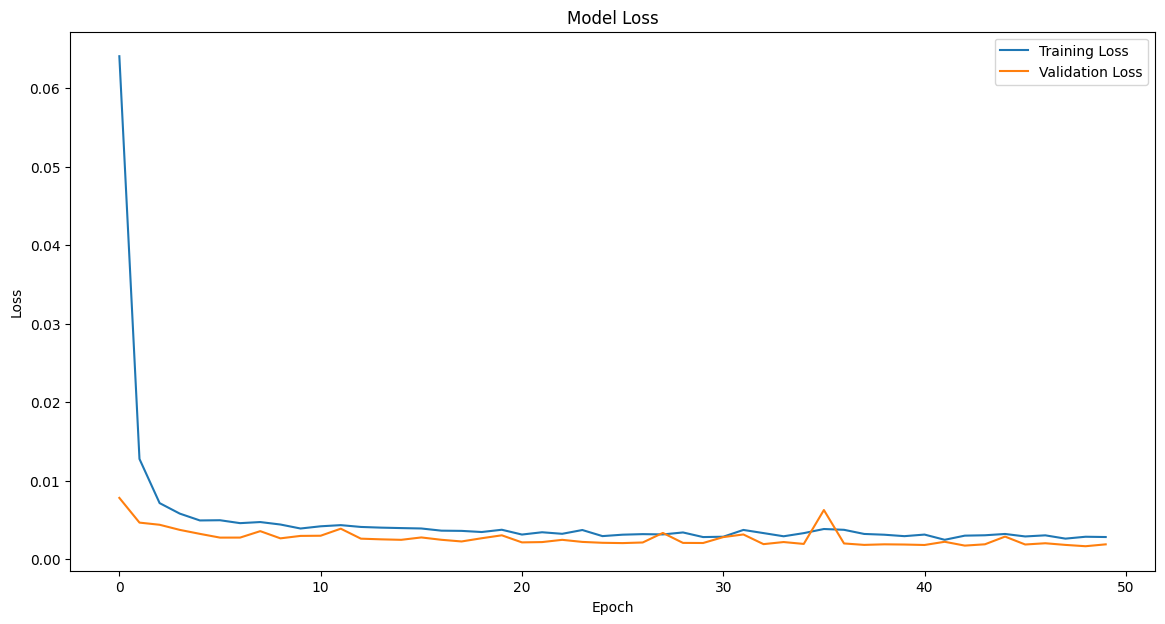

Current Price: $129.93
MACD Signal: Sell
RSI: Hold
Price Forecast: Buy


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

# 1. Збір даних
ticker = 'AAPL'  # Приклад: Apple Inc.
start_date = '2020-01-01'
end_date = '2023-01-01'

data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Close']]  # Використовуємо лише ціну закриття

# Додаємо технічні індикатори
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['RSI'] = 100 - (100 / (1 + (data['Close'].diff(1).clip(lower=0).rolling(window=14).mean() /
                                 data['Close'].diff(1).clip(upper=0).abs().rolling(window=14).mean())))

data = data.dropna()

# 2. Попередня обробка даних
features = data[['Close', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'Signal', 'RSI']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Створення навчальних і тестових наборів даних
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Цільова змінна - ціна закриття
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
X_train, y_train = X[:-30], y[:-30]
X_test, y_test = X[-30:], y[-30:]

# 3. Розробка моделі LSTM з Dropout
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Тренування моделі
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 4. Прогнозування
def predict_future(data, model, time_step):
    predictions = []
    input_seq = data[-time_step:]
    input_seq = input_seq.reshape((1, time_step, input_seq.shape[1]))
    for _ in range(30):
        prediction = model.predict(input_seq)
        predictions.append(prediction[0, 0])
        input_seq = np.roll(input_seq, shift=-1, axis=1)
        input_seq[0, -1, 0] = prediction[0, 0]
    return np.array(predictions)

predicted_prices = predict_future(scaled_data, model, time_step)
predicted_prices = scaler.inverse_transform(np.concatenate(
    (np.array(predicted_prices).reshape(-1, 1),
     np.tile(scaled_data[-1, 1:].reshape(1, -1), (30, 1))),
    axis=1))[:, 0]

# 5. Оцінка моделі
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(np.concatenate((predicted_test, X_test[:, -1, 1:]), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]
mse = mean_squared_error(y_test, predicted_test)
print(f"Mean Squared Error on Test Data: {mse:.4f}")

# 6. Візуалізація результатів
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Historical Prices')

# Визначення майбутніх дат
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates, predicted_prices, label='Predicted Prices', color='red')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.legend()
plt.show()

# Візуалізація процесу навчання
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# 7. Рекомендації на основі прогнозів
def generate_recommendation(current_price, predicted_prices, data):
    last_row = data.iloc[-1]
    recommendation = []

    # Торгова стратегія на основі MACD
    if last_row['MACD'] > last_row['Signal']:
        recommendation.append("MACD Signal: Buy")
    else:
        recommendation.append("MACD Signal: Sell")

    # Торгова стратегія на основі RSI
    if last_row['RSI'] < 30:
        recommendation.append("RSI: Buy")
    elif last_row['RSI'] > 70:
        recommendation.append("RSI: Sell")
    else:
        recommendation.append("RSI: Hold")

    # Прогноз на основі прогнозованої ціни
    if predicted_prices[-1] > current_price:
        recommendation.append("Price Forecast: Buy")
    elif predicted_prices[-1] < current_price:
        recommendation.append("Price Forecast: Sell")
    else:
        recommendation.append("Price Forecast: Hold")

    return recommendation

current_price = data['Close'].iloc[-1]
recommendations = generate_recommendation(current_price, predicted_prices, data)
print(f"Current Price: ${current_price:.2f}")
for rec in recommendations:
    print(rec)









RFM

In [ ]:
import pandas as pd
from datetime import datetime
from google.colab import files

# Завантаження файлу вручну
uploaded = files.upload()

# Після завантаження отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)

# Очищення даних: видалення відсутніх ID клієнтів і негативних значень кількості
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Поточна дата для розрахунку Recency
current_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Розрахунок RFM-аналізу для кожного CustomerID
rfm = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (current_date - x.max()).days),  # Днів від останньої транзакції
    Frequency=('InvoiceNo', 'nunique'),                               # Кількість унікальних транзакцій
    Monetary=('TotalPrice', 'sum')                                    # Загальний дохід
).reset_index()

# Відновлення порядку CustomerID з оригінальної таблиці
ordered_rfm = pd.merge(df[['CustomerID']].drop_duplicates(), rfm, on='CustomerID', how='left')

# Збереження результатів у файл Excel
ordered_rfm.to_excel('rfm_per_customer.xlsx', index=False)

# Завантаження файлу на локальний комп'ютер
files.download('rfm_per_customer.xlsx')

# Виведення результатів (перші кілька рядків)
print(ordered_rfm.head())




Saving Online Retail.xlsx to Online Retail (1).xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   CustomerID  Recency  Frequency  Monetary
0     17850.0      372         34   5391.21
1     13047.0       32         10   3237.54
2     12583.0        3         15   7281.38
3     13748.0       96          5    948.25
4     15100.0      334          3    876.00


Кластеризація

Saving rfm_per_customer.xlsx to rfm_per_customer.xlsx


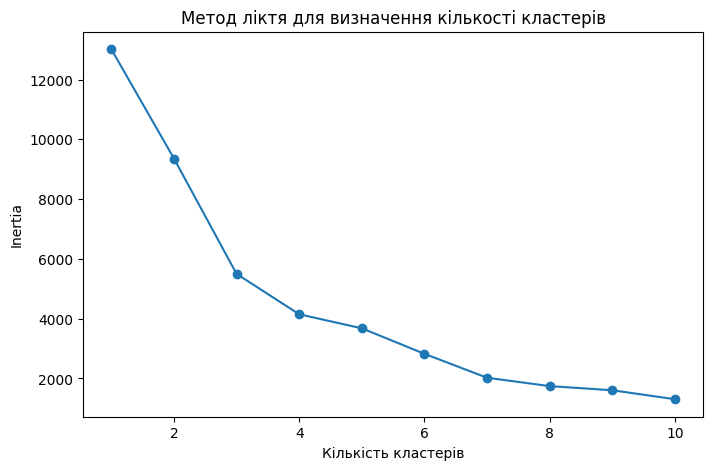

Опис кластерів:
   Cluster  Recency_mean  Frequency_mean  Monetary_mean  Count
0        0     42.609554        4.036943    1521.662708   3140
1        1    247.312268        1.552974     556.665949   1076
2        2      6.000000       83.625000  165340.695000      8
3        3     12.930435       30.608696   19232.077217    115


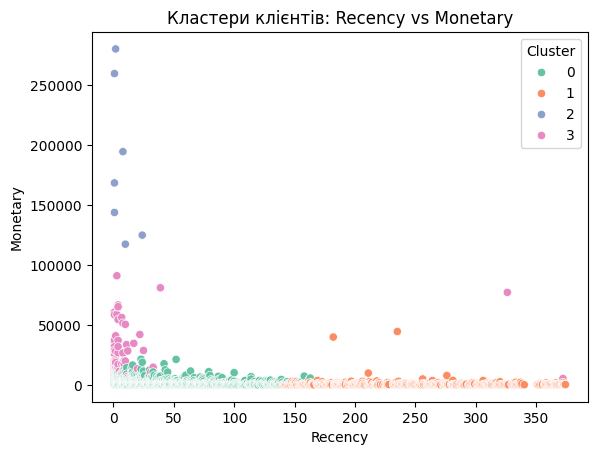

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Завантаження файлу вручну
uploaded = files.upload()

# Отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
rfm = pd.read_excel(file_name)

# Масштабування даних для кластеризації
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Визначення оптимальної кількості кластерів за допомогою методу "лікоть"
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Побудова графіка "лікоть"
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Метод ліктя для визначення кількості кластерів')
plt.xlabel('Кількість кластерів')
plt.ylabel('Inertia')
plt.show()

# Вибір оптимальної кількості кластерів (наприклад, 4)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Аналіз отриманих кластерів
cluster_summary = rfm.groupby('Cluster').agg(
    Recency_mean=('Recency', 'mean'),
    Frequency_mean=('Frequency', 'mean'),
    Monetary_mean=('Monetary', 'mean'),
    Count=('CustomerID', 'count')
).reset_index()

print("Опис кластерів:")
print(cluster_summary)

# Візуалізація кластерів (Recency vs. Monetary)
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Кластери клієнтів: Recency vs Monetary')
plt.show()

# Збереження результатів у файл Excel
rfm.to_excel('rfm_with_clusters.xlsx', index=False)
files.download('rfm_with_clusters.xlsx')





Кластеризація + персоналізована ціна

Saving rfm_per_customer.xlsx to rfm_per_customer (2).xlsx


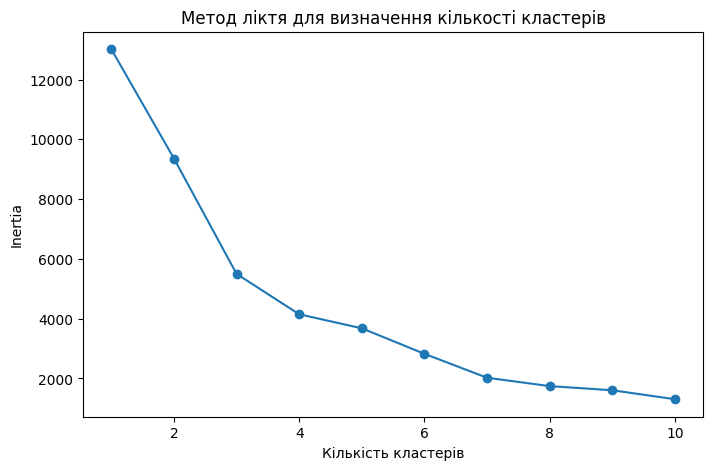

Опис кластерів:
   Cluster  Recency_mean  Frequency_mean  Monetary_mean  Count
0        0     42.609554        4.036943    1521.662708   3140
1        1    247.312268        1.552974     556.665949   1076
2        2      6.000000       83.625000  165340.695000      8
3        3     12.930435       30.608696   19232.077217    115


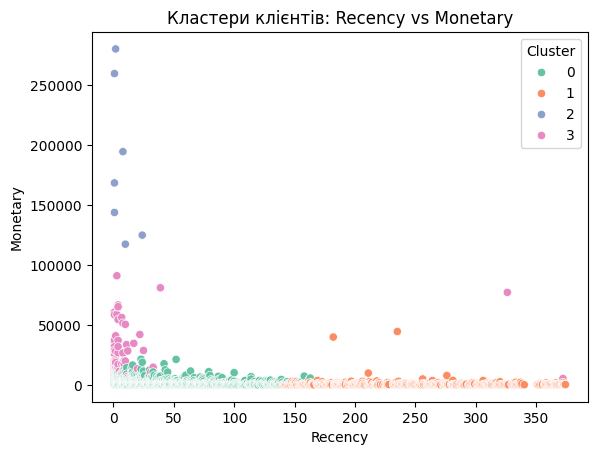

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Завантаження файлу вручну
uploaded = files.upload()

# Отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
rfm = pd.read_excel(file_name)

# Масштабування даних для кластеризації
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Визначення оптимальної кількості кластерів за допомогою методу "лікоть"
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Побудова графіка "лікоть"
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Метод ліктя для визначення кількості кластерів')
plt.xlabel('Кількість кластерів')
plt.ylabel('Inertia')
plt.show()

# Вибір оптимальної кількості кластерів (наприклад, 4)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Аналіз отриманих кластерів
cluster_summary = rfm.groupby('Cluster').agg(
    Recency_mean=('Recency', 'mean'),
    Frequency_mean=('Frequency', 'mean'),
    Monetary_mean=('Monetary', 'mean'),
    Count=('CustomerID', 'count')
).reset_index()

print("Опис кластерів:")
print(cluster_summary)

# Візуалізація кластерів (Recency vs. Monetary)
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Кластери клієнтів: Recency vs Monetary')
plt.show()

# Додавання персоналізованої ціни
base_price = 100  # Базова ціна
cluster_multipliers = {
    0: 0.8,  # Знижка для кластера 0
    1: 0.9,  # Невелика знижка для кластера 1
    2: 1.2,  # Преміальна ціна для кластера 2
    3: 1.0   # Стандартна ціна для кластера 3
}

# Персоналізована ціна для кожного клієнта
rfm['PersonalizedPrice'] = rfm['Cluster'].map(cluster_multipliers) * base_price

# Гарантуємо, що ціна не може бути негативною
rfm['PersonalizedPrice'] = rfm['PersonalizedPrice'].clip(lower=0)

# Збереження результатів у файл Excel
rfm.to_excel('rfm_with_personalized_prices.xlsx', index=False)
files.download('rfm_with_personalized_prices.xlsx')




Когортний аналіз

Saving Online Retail.xlsx to Online Retail (4).xlsx


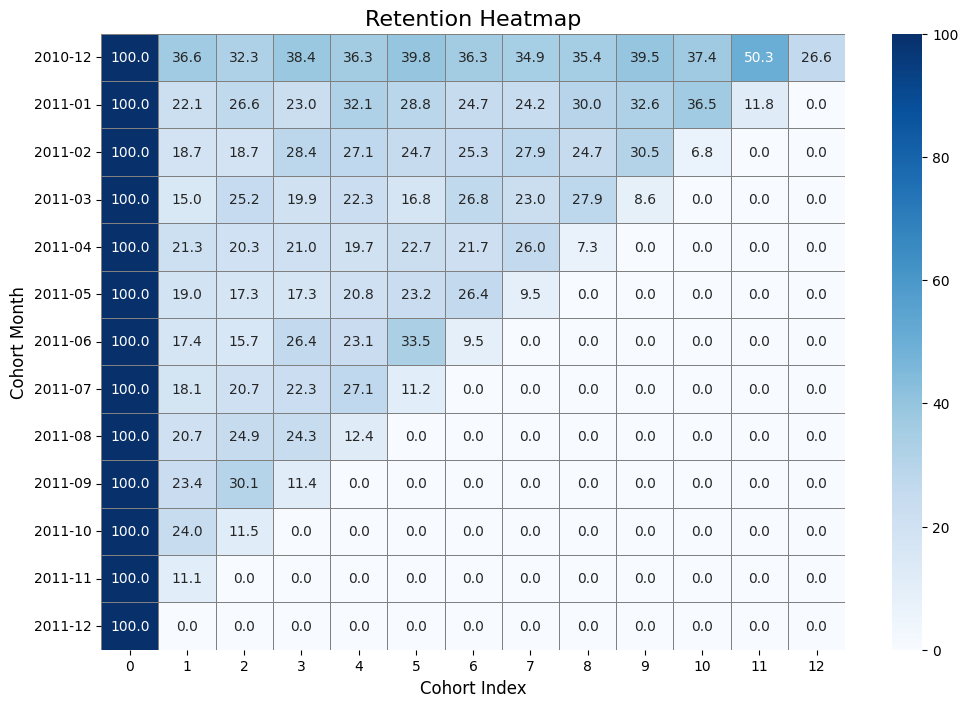

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files

# Завантаження файлу вручну
uploaded = files.upload()

# Отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)

# Очищення даних: видалення відсутніх ID клієнтів і негативних значень кількості
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Перетворення InvoiceDate у формат datetime
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Додавання місяця першої покупки для кожного клієнта
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Додавання місяця кожної покупки
df['PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')

# Розрахунок когортного індексу (номер місяця від першої покупки)
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# Когортний аналіз: кількість унікальних клієнтів у кожному періоді
cohort_table = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().unstack(fill_value=0)

# Підрахунок відсотків утримання (retention rate)
cohort_sizes = cohort_table.iloc[:, 0]
retention_table = cohort_table.divide(cohort_sizes, axis=0) * 100

# Побудова теплової карти утримання
plt.figure(figsize=(12, 8))
sns.heatmap(
    retention_table,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar=True,
    linewidths=0.5,
    linecolor="gray"
)
plt.title('Retention Heatmap', fontsize=16)
plt.ylabel('Cohort Month', fontsize=12)
plt.xlabel('Cohort Index', fontsize=12)
plt.show()

# Збереження таблиць у Excel
with pd.ExcelWriter('cohort_analysis.xlsx') as writer:
    cohort_table.to_excel(writer, sheet_name='Cohort Table')
    retention_table.to_excel(writer, sheet_name='Retention Table')

# Завантаження результатів
files.download('cohort_analysis.xlsx')







Прогнозовані знижки за когортами на основі середніх показників

Saving Online Retail.xlsx to Online Retail (6).xlsx
    CohortMonth     Recency   Frequency     Monetary
0         24132   96.859887  191.335593  5098.472565
1         24133  116.762590  114.568345  2699.957508
2         24134  125.694737   80.142105  1562.833895
3         24135  126.732301   75.827434  1424.245442
4         24136  125.796667   64.153333  1088.736770
5         24137  107.426056   55.218310  1604.033028
6         24138   93.607438   57.314050  1129.980289
7         24139   87.361702   56.031915   768.448622
8         24140   73.088757   76.976331  1160.053550
9         24141   54.505017   47.461538   780.256926
10        24142   41.815642   45.365922   635.110447
11        24143   20.225309   38.061728   468.755340
12        24144    3.487805   24.000000   659.986829


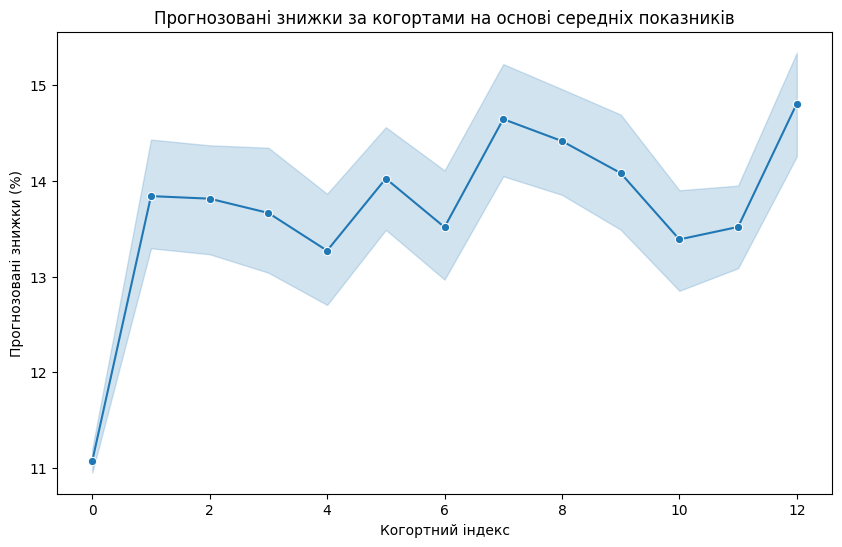

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle

# Завантаження файлу вручну
uploaded = files.upload()

# Отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)

# Очищення даних: видалення відсутніх ID клієнтів і негативних значень кількості
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']  # Виправлено: змінили на .loc

# Перетворення InvoiceDate у формат datetime
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Виправлено: змінили на .loc

# Додавання місяця першої покупки для кожного клієнта
df.loc[:, 'CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')  # Виправлено: змінили на .loc

# Додавання місяця кожної покупки
df.loc[:, 'PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')  # Виправлено: змінили на .loc

# Розрахунок когортного індексу (номер місяця від першої покупки)
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# RFM-аналіз
# 1. Recency (R) - час від останньої покупки
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

# 2. Frequency (F) - кількість покупок
frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

# 3. Monetary (M) - загальна сума витрат
monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

# Об'єднуємо RFM дані
rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')

# Додавання когортних даних до RFM
cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')

# Перетворюємо CohortMonth в рік та місяць як числові значення для моделі
rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

# Підрахунок середніх значень для кожної когортної групи
cohort_means = rfm.groupby('CohortMonth').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# Переглядаємо середні значення для кожної когортної групи
print(cohort_means)

# Генерація знижок на основі порівняння середніх показників когорт
def generate_discounts(row, cohort_means):
    # Для кожної когортної групи, порівнюємо частоту та витрати з середнім значенням
    cohort_group = cohort_means[cohort_means['CohortMonth'] == row['CohortMonth']]

    if cohort_group.empty:
        return 10  # Якщо групи не знайдено, даємо стандартну знижку

    mean_frequency = cohort_group['Frequency'].values[0]
    mean_monetary = cohort_group['Monetary'].values[0]

    # Якщо частота і витрати вище середнього, знижка більша
    if row['Frequency'] > mean_frequency and row['Monetary'] > mean_monetary:
        return 20  # Велика знижка
    elif row['Frequency'] > mean_frequency or row['Monetary'] > mean_monetary:
        return 15  # Середня знижка
    else:
        return 10  # Маленька знижка

# Додавання стовпця з прогнозованими знижками на основі порівняння з середніми показниками когорт
rfm['PredictedDiscount'] = rfm.apply(generate_discounts, axis=1, cohort_means=cohort_means)

# Візуалізація прогнозованих знижок
plt.figure(figsize=(10, 6))
sns.lineplot(x='CohortIndex', y='PredictedDiscount', data=rfm, marker='o')
plt.title('Прогнозовані знижки за когортами на основі середніх показників')
plt.xlabel('Когортний індекс')
plt.ylabel('Прогнозовані знижки (%)')
plt.show()

# Завантаження результатів з прогнозованими знижками в Excel
with pd.ExcelWriter('rfm_cohort_analysis_with_discount_rules.xlsx') as writer:
    rfm.to_excel(writer, sheet_name='RFM & Cohort Data')

# Завантаження результатів
files.download('rfm_cohort_analysis_with_discount_rules.xlsx')







Прогнозовані знижки на основі зворотного зв’язку

Saving Online Retail.xlsx to Online Retail (15).xlsx


Training Episodes: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


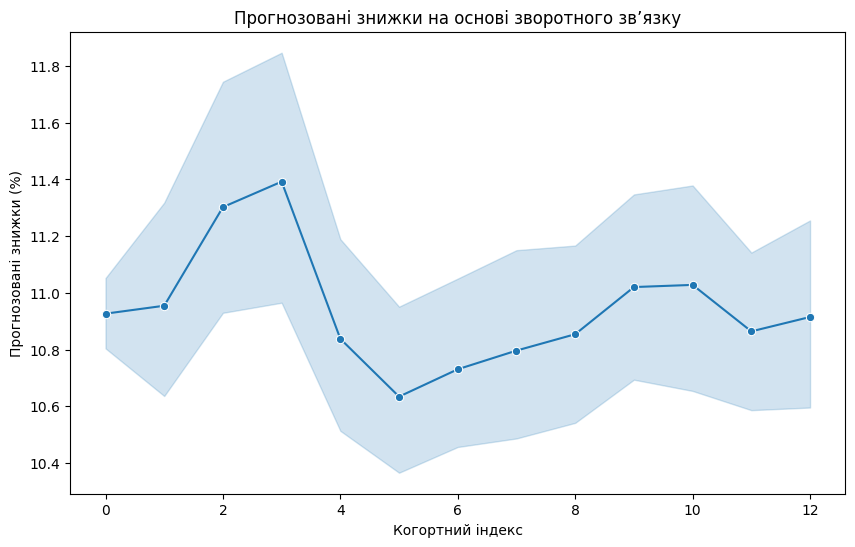

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import files
from sklearn.preprocessing import StandardScaler
import random
from tqdm import tqdm

# Завантаження файлу вручну
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df['PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')
rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

class DiscountRLAgent:
    def __init__(self, n_actions=3):
        self.n_actions = n_actions
        self.q_table = np.zeros((len(rfm), n_actions))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.exploration_rate = 0.1

    def choose_action(self, state_idx):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.randint(0, self.n_actions - 1)
        else:
            return np.argmax(self.q_table[state_idx])

    def update_q_table(self, state_idx, action, reward, next_state_idx):
        best_next_action = np.argmax(self.q_table[next_state_idx])
        self.q_table[state_idx, action] += self.learning_rate * (
            reward + self.discount_factor * self.q_table[next_state_idx, best_next_action] - self.q_table[state_idx, action]
        )

def calculate_feedback_reward(row, previous_purchases):
    customer_id = row['CustomerID']
    new_purchases = row['Monetary']
    previous_purchases = previous_purchases.get(customer_id, 0)
    purchase_diff = new_purchases - previous_purchases

    if purchase_diff > 100:
        return 50 + purchase_diff * 0.2
    elif purchase_diff > 0:
        return 20 + purchase_diff * 0.1
    elif purchase_diff == 0:
        return 5
    else:
        return -10

agent = DiscountRLAgent(n_actions=3)

n_episodes = 100
customer_purchases = df.groupby('CustomerID')['TotalPrice'].sum().to_dict()

for episode in tqdm(range(n_episodes), desc="Training Episodes"):
    for idx in range(len(rfm)):
        row = rfm.iloc[idx]
        state_idx = idx
        action = agent.choose_action(state_idx)
        discount = [0.1, 0.15, 0.2][action]
        adjusted_price = customer_purchases[row['CustomerID']] * (1 - discount)
        reward = calculate_feedback_reward(row, customer_purchases)
        next_state_idx = state_idx
        agent.update_q_table(state_idx, action, reward, next_state_idx)

def apply_discount_policy(row, agent):
    state_idx = row.name
    action = np.argmax(agent.q_table[state_idx])
    discount_percentage = [10, 15, 20][action]
    return discount_percentage

rfm['PredictedDiscount'] = rfm.apply(apply_discount_policy, axis=1, agent=agent)

plt.figure(figsize=(10, 6))
sns.lineplot(x='CohortIndex', y='PredictedDiscount', data=rfm, marker='o')
plt.title('Прогнозовані знижки на основі зворотного зв’язку')
plt.xlabel('Когортний індекс')
plt.ylabel('Прогнозовані знижки (%)')
plt.show()

with pd.ExcelWriter('rfm_feedback_rl_discount.xlsx') as writer:
    rfm.to_excel(writer, sheet_name='RFM & Feedback Data')

files.download('rfm_feedback_rl_discount.xlsx')








Метод навчання з підкріпленням (Q-learning) на основі нейронних мереж

Saving Online Retail.xlsx to Online Retail (4).xlsx


Training Episodes: 100%|██████████| 50/50 [40:12<00:00, 48.26s/it]


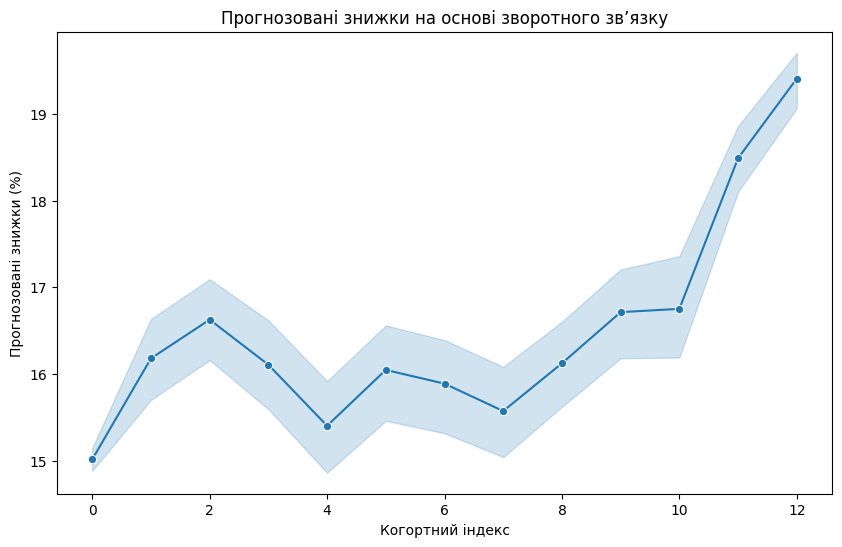

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import files
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from collections import deque
import random

# Завантаження файлу вручну
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df['PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')
rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

# Агент DQN
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.995, exploration_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.exploration_min = exploration_min
        self.model = self._build_model()

    def _build_model(self):
        # Нейронна мережа для апроксимації Q-функції
        model = Sequential([
            Input(shape=(self.state_size,)),
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.discount_factor * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

# Функція для розрахунку нагороди
def calculate_feedback_reward(row, previous_purchases):
    customer_id = row['CustomerID']
    new_purchases = row['Monetary']
    previous_purchases = previous_purchases.get(customer_id, 0)
    purchase_diff = new_purchases - previous_purchases

    if purchase_diff > 100:
        return 50 + purchase_diff * 0.2
    elif purchase_diff > 0:
        return 20 + purchase_diff * 0.1
    elif purchase_diff == 0:
        return 5
    else:
        return -10

# Параметри агента
state_size = 3  # Recency, Frequency, Monetary
action_size = 3  # Знижки: 10%, 15%, 20%
agent = DQNAgent(state_size, action_size)

# Підготовка даних
rfm_states = rfm[['Recency', 'Frequency', 'Monetary']].values
scaler = StandardScaler()
rfm_states = scaler.fit_transform(rfm_states)

customer_purchases = df.groupby('CustomerID')['TotalPrice'].sum().to_dict()

# Навчання агента
n_episodes = 50
batch_size = 32

for episode in tqdm(range(n_episodes), desc="Training Episodes"):
    for idx in range(len(rfm)):
        row = rfm.iloc[idx]
        state = np.reshape(rfm_states[idx], [1, state_size])
        action = agent.act(state)
        discount = [0.1, 0.15, 0.2][action]
        adjusted_price = customer_purchases[row['CustomerID']] * (1 - discount)
        reward = calculate_feedback_reward(row, customer_purchases)
        next_state = state  # Для простоти, припустимо, що стан не змінюється
        done = True  # Епізод завершується після одного кроку
        agent.remember(state, action, reward, next_state, done)

    agent.replay(batch_size)

# Застосування політики агента
def apply_discount_policy(row, agent):
    state_idx = row.name
    state = np.reshape(rfm_states[state_idx], [1, state_size])
    action = np.argmax(agent.model.predict(state, verbose=0))
    discount_percentage = [10, 15, 20][action]
    return discount_percentage

rfm['PredictedDiscount'] = rfm.apply(apply_discount_policy, axis=1, agent=agent)

# Візуалізація
plt.figure(figsize=(10, 6))
sns.lineplot(x='CohortIndex', y='PredictedDiscount', data=rfm, marker='o')
plt.title('Прогнозовані знижки на основі зворотного зв’язку')
plt.xlabel('Когортний індекс')
plt.ylabel('Прогнозовані знижки (%)')
plt.show()

# Збереження результатів
with pd.ExcelWriter('rfm_feedback_dqn_discount.xlsx') as writer:
    rfm.to_excel(writer, sheet_name='RFM & Feedback Data')

files.download('rfm_feedback_dqn_discount.xlsx')



Gradient Boosting

Saving Online Retail.xlsx to Online Retail (3).xlsx
Найкращі параметри: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}

Показники для тренувальних даних:
Mean Squared Error (Train): 0.000969
R² (Train): 0.999872
Mean Absolute Error (Train): 0.016462

Показники для тестових даних:
Mean Squared Error (Test): 0.000261
R² (Test): 0.999964
Mean Absolute Error (Test): 0.015262

Модель не перенавчена.

Крос-валідація (MSE): 0.010899
Крос-валідація (R²): 0.998524


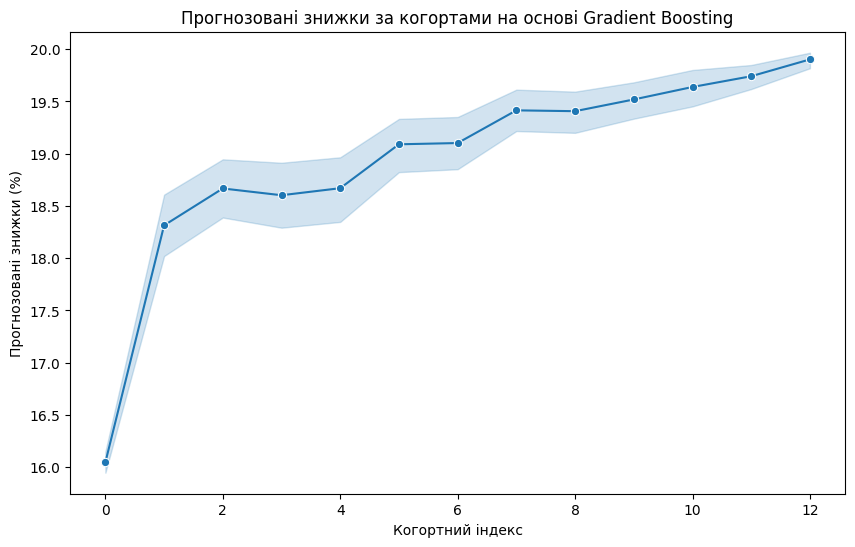

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

# Завантаження файлу вручну
uploaded = files.upload()

# Отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)

# Очищення даних: видалення відсутніх ID клієнтів і негативних значень кількості
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Перетворення InvoiceDate у формат datetime
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Додавання місяця першої покупки для кожного клієнта
df.loc[:, 'CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Додавання місяця кожної покупки
df.loc[:, 'PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')

# Розрахунок когортного індексу (номер місяця від першої покупки)
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# RFM-аналіз
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')

rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

def generate_discounts(row):
    if row['Frequency'] > 10 and row['Monetary'] > 500:
        return 20
    elif row['Frequency'] > 5 or row['Monetary'] > 100:
        return 15
    else:
        return 10

rfm['Discount'] = rfm.apply(generate_discounts, axis=1)

features = ['Recency', 'Frequency', 'Monetary', 'CohortMonth']
X = rfm[features]
y = rfm['Discount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [50, 75, 100],       # Зменшено кількість дерев
    'learning_rate': [0.01, 0.05],      # Навчальна швидкість
    'max_depth': [3, 5],                # Обмежено глибину дерева
    'min_samples_split': [10, 15],      # Збільшено мін. кількість зразків для поділу
    'min_samples_leaf': [3, 5],         # Налаштовано мін. зразки в листі
    'subsample': [0.8]                  # Використано subsample для зменшення варіативності
}

model = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Найкращі параметри:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nПоказники для тренувальних даних:")
print(f"Mean Squared Error (Train): {train_mse:.6f}")
print(f"R² (Train): {train_r2:.6f}")
print(f"Mean Absolute Error (Train): {train_mae:.6f}")

print(f"\nПоказники для тестових даних:")
print(f"Mean Squared Error (Test): {test_mse:.6f}")
print(f"R² (Test): {test_r2:.6f}")
print(f"Mean Absolute Error (Test): {test_mae:.6f}")

if train_r2 > test_r2:
    print("\nМодель може бути перенавчена (overfitting).")
else:
    print("\nМодель не перенавчена.")

cv_scores = cross_val_score(best_model, scaler.fit_transform(X), y, cv=5, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(best_model, scaler.fit_transform(X), y, cv=5, scoring='r2')

print(f"\nКрос-валідація (MSE): {-cv_scores.mean():.6f}")
print(f"Крос-валідація (R²): {cv_r2_scores.mean():.6f}")

rfm['PredictedDiscount'] = best_model.predict(scaler.transform(rfm[features]))

plt.figure(figsize=(10, 6))
sns.lineplot(x='CohortIndex', y='PredictedDiscount', data=rfm, marker='o')
plt.title('Прогнозовані знижки за когортами на основі Gradient Boosting')
plt.xlabel('Когортний індекс')
plt.ylabel('Прогнозовані знижки (%)')
plt.show()

with pd.ExcelWriter('rfm_cohort_analysis_gradient_boosting.xlsx') as writer:
    rfm.to_excel(writer, sheet_name='RFM & Cohort Data')

files.download('rfm_cohort_analysis_gradient_boosting.xlsx')








XGBoost

Saving Online Retail.xlsx to Online Retail.xlsx


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:59:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Результати крос-валідації:
   train-rmse-mean  train-rmse-std  train-mae-mean  train-mae-std  \
0         2.600725        0.006531        2.467565       0.007870   
1         2.471714        0.006328        2.344768       0.007527   
2         2.348979        0.006151        2.228001       0.007212   
3         2.232640        0.005947        2.117207       0.006919   
4         2.121939        0.005825        2.011873       0.006656   
5         2.016825        0.005631        1.911797       0.006380   
6         1.916805        0.005515        1.816613       0.006164   
7         1.821850        0.005432        1.726241       0.005967   
8         1.731662        0.005408        1.640373       0.005788   
9         1.646094        0.005205        1.558835       0.005527   

   test-rmse-mean  test-rmse-std  test-mae-mean  test-mae-std  
0        2.602046       0.025466       2.469069      0.013558  
1        2.473115       0.024660       2.346367      0.013201  
2        2.350494    

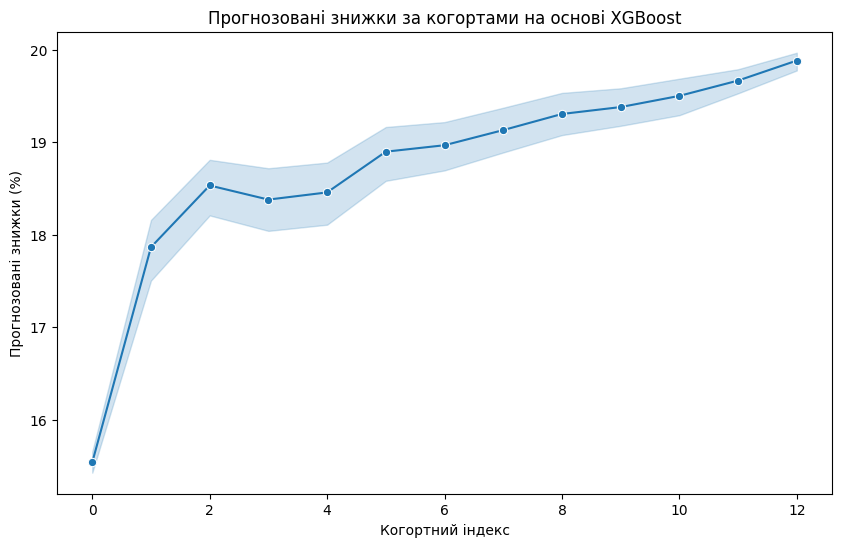

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from xgboost import XGBRegressor, cv, DMatrix
from xgboost.sklearn import XGBRegressor

# Завантаження файлу вручну
uploaded = files.upload()

# Отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)

# Очищення даних: видалення відсутніх ID клієнтів і негативних значень кількості
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Перетворення InvoiceDate у формат datetime
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Додавання місяця першої покупки для кожного клієнта
df.loc[:, 'CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Додавання місяця кожної покупки
df.loc[:, 'PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')

# Розрахунок когортного індексу (номер місяця від першої покупки)
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# RFM-аналіз
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')

rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

def generate_discounts(row):
    if row['Frequency'] > 10 and row['Monetary'] > 500:
        return 20
    elif row['Frequency'] > 5 or row['Monetary'] > 100:
        return 15
    else:
        return 10

rfm['Discount'] = rfm.apply(generate_discounts, axis=1)

features = ['Recency', 'Frequency', 'Monetary', 'CohortMonth']
X = rfm[features]
y = rfm['Discount']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ручне налаштування параметрів моделі
model = XGBRegressor(
    n_estimators=100,      # Кількість дерев
    learning_rate=0.05,    # Навчальна швидкість
    max_depth=5,           # Максимальна глибина дерева
    min_child_weight=3,    # Мінімальна вага кожної листової одиниці
    subsample=0.8,         # Частина зразків, що використовуються для тренування
    random_state=42
)

# Використання вбудованої функції крос-валідації
dmatrix = DMatrix(X_scaled, label=y)
cv_results = cv(
    dtrain=dmatrix,
    params=model.get_params(),
    nfold=5,
    metrics=('rmse', 'mae'),
    as_pandas=True,
    seed=42
)

print("Результати крос-валідації:")
print(cv_results)

# Навчання моделі
model.fit(X_scaled, y)

# Прогнозування
y_pred = model.predict(X_scaled)

# Оцінка моделі
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"\nПоказники моделі:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R²: {r2:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")

rfm['PredictedDiscount'] = y_pred

# Візуалізація прогнозованих знижок
plt.figure(figsize=(10, 6))
sns.lineplot(x='CohortIndex', y='PredictedDiscount', data=rfm, marker='o')
plt.title('Прогнозовані знижки за когортами на основі XGBoost')
plt.xlabel('Когортний індекс')
plt.ylabel('Прогнозовані знижки (%)')
plt.show()

# Збереження результатів в Excel
with pd.ExcelWriter('rfm_cohort_analysis_xgboost.xlsx') as writer:
    rfm.to_excel(writer, sheet_name='RFM & Cohort Data')

# Завантаження файлу
files.download('rfm_cohort_analysis_xgboost.xlsx')







LightGBM

Saving Online Retail.xlsx to Online Retail (2).xlsx
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 3471, number of used features: 4
[LightGBM] [Info] Start training from score 17.673581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

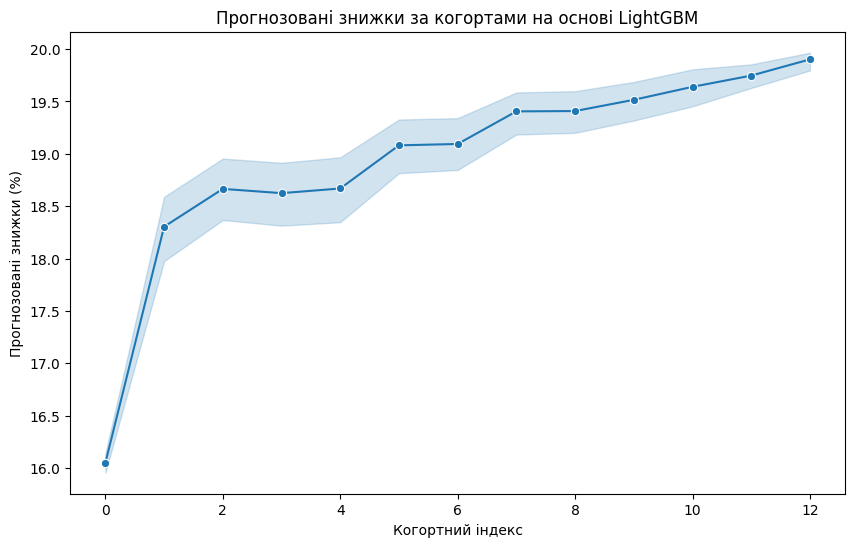

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import lightgbm as lgb
import warnings

# Ігнорування FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Завантаження файлу вручну
uploaded = files.upload()

# Отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)

# Очищення даних: видалення відсутніх ID клієнтів і негативних значень кількості
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]

# Обчислення TotalPrice
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Перетворення InvoiceDate у формат datetime
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Додавання місяця першої покупки для кожного клієнта
df.loc[:, 'CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Додавання місяця кожної покупки
df.loc[:, 'PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')

# Розрахунок когортного індексу (номер місяця від першої покупки)
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# RFM-аналіз
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')

rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

# Функція для генерації знижок
def generate_discounts(row):
    if row['Frequency'] > 10 and row['Monetary'] > 500:
        return 20
    elif row['Frequency'] > 5 or row['Monetary'] > 100:
        return 15
    else:
        return 10

rfm['Discount'] = rfm.apply(generate_discounts, axis=1)

# Вибір ознак та цільової змінної
features = ['Recency', 'Frequency', 'Monetary', 'CohortMonth']
X = rfm[features]
y = rfm['Discount']

# Розбиття на тренувальні та тестові набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизація даних
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Параметри для GridSearchCV
param_grid_lgb = {
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, -1],
    'num_leaves': [15, 31],
    'min_child_samples': [10, 20],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

# Ініціалізація моделі LightGBM
model_lgb = lgb.LGBMRegressor(random_state=42)

# Налаштування GridSearchCV для LightGBM
grid_search_lgb = GridSearchCV(estimator=model_lgb, param_grid=param_grid_lgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lgb.fit(X_train_scaled, y_train)

# Найкращі параметри
print("Найкращі параметри (LightGBM):", grid_search_lgb.best_params_)

# Найкраща модель LightGBM
best_model_lgb = grid_search_lgb.best_estimator_

# Прогнози
y_pred_train_lgb = best_model_lgb.predict(X_train_scaled)
y_pred_test_lgb = best_model_lgb.predict(X_test_scaled)

# Метрики
train_mse_lgb = mean_squared_error(y_train, y_pred_train_lgb)
test_mse_lgb = mean_squared_error(y_test, y_pred_test_lgb)
train_r2_lgb = r2_score(y_train, y_pred_train_lgb)
test_r2_lgb = r2_score(y_test, y_pred_test_lgb)
train_mae_lgb = mean_absolute_error(y_train, y_pred_train_lgb)
test_mae_lgb = mean_absolute_error(y_test, y_pred_test_lgb)

# Виведення результатів
print(f"\nПоказники для тренувальних даних (LightGBM):")
print(f"Mean Squared Error (Train): {train_mse_lgb:.6f}")
print(f"R² (Train): {train_r2_lgb:.6f}")
print(f"Mean Absolute Error (Train): {train_mae_lgb:.6f}")

print(f"\nПоказники для тестових даних (LightGBM):")
print(f"Mean Squared Error (Test): {test_mse_lgb:.6f}")
print(f"R² (Test): {test_r2_lgb:.6f}")
print(f"Mean Absolute Error (Test): {test_mae_lgb:.6f}")

# Перевірка на перенавчання
if train_r2_lgb > test_r2_lgb:
    print("\nМодель може бути перенавчена (overfitting).")
else:
    print("\nМодель не перенавчена.")

# Крос-валідація
cv_scores_lgb = cross_val_score(best_model_lgb, scaler.fit_transform(X), y, cv=5, scoring='neg_mean_squared_error')
cv_r2_scores_lgb = cross_val_score(best_model_lgb, scaler.fit_transform(X), y, cv=5, scoring='r2')

print(f"\nКрос-валідація (MSE, LightGBM): {-cv_scores_lgb.mean():.6f}")
print(f"Крос-валідація (R², LightGBM): {cv_r2_scores_lgb.mean():.6f}")

# Прогноз для всього набору даних
rfm['PredictedDiscount'] = best_model_lgb.predict(scaler.transform(rfm[features]))

# Візуалізація
plt.figure(figsize=(10, 6))
sns.lineplot(x='CohortIndex', y='PredictedDiscount', data=rfm, marker='o')
plt.title('Прогнозовані знижки за когортами на основі LightGBM')
plt.xlabel('Когортний індекс')
plt.ylabel('Прогнозовані знижки (%)')
plt.show()

# Збереження результатів
with pd.ExcelWriter('rfm_cohort_analysis_lightgbm.xlsx') as writer:
    rfm.to_excel(writer, sheet_name='RFM & Cohort Data')

files.download('rfm_cohort_analysis_lightgbm.xlsx')



RFM-D

In [ ]:
import pandas as pd
from datetime import datetime
from google.colab import files

# Завантаження файлу вручну
uploaded = files.upload()

# Після завантаження отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)

# Очищення даних: видалення відсутніх ID клієнтів і негативних значень кількості
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Поточна дата для розрахунку Recency
current_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Розрахунок RFM-D аналізу для кожного CustomerID
rfm_d = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (current_date - x.max()).days),  # Днів від останньої транзакції
    Frequency=('InvoiceNo', 'nunique'),                               # Кількість унікальних транзакцій
    Monetary=('TotalPrice', 'sum'),                                   # Загальний дохід
    Diversity=('Description', 'nunique')                             # Кількість унікальних назв продуктів
).reset_index()

# Відновлення порядку CustomerID з оригінальної таблиці
ordered_rfm_d = pd.merge(df[['CustomerID']].drop_duplicates(), rfm_d, on='CustomerID', how='left')

# Збереження результатів у файл Excel
ordered_rfm_d.to_excel('rfm_d_per_customer.xlsx', index=False)

# Завантаження файлу на локальний комп'ютер
files.download('rfm_d_per_customer.xlsx')

# Виведення результатів (перші кілька рядків)
print(ordered_rfm_d.head())


Saving Online Retail.xlsx to Online Retail.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   CustomerID  Recency  Frequency  Monetary  Diversity
0     17850.0      372         34   5391.21         21
1     13047.0       32         10   3237.54        106
2     12583.0        3         15   7281.38        117
3     13748.0       96          5    948.25         24
4     15100.0      334          3    876.00          1


Когортний аналіз + KMeans (метод ліктя)

Saving Online Retail.xlsx to Online Retail (1).xlsx


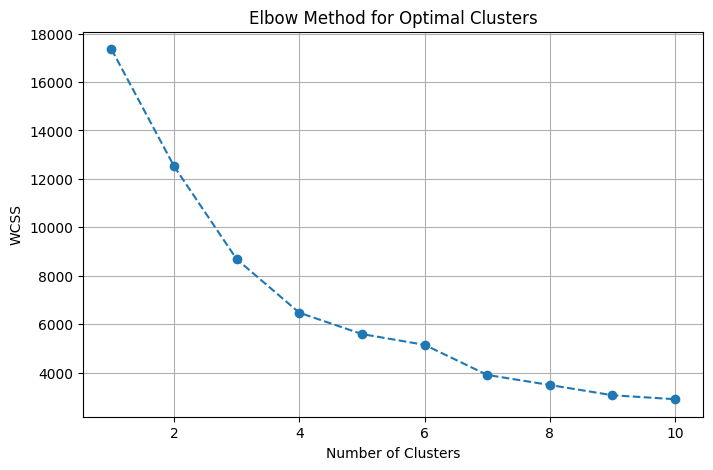

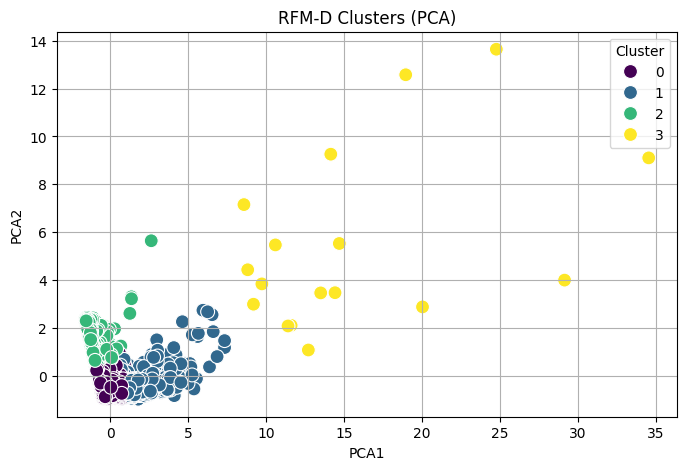

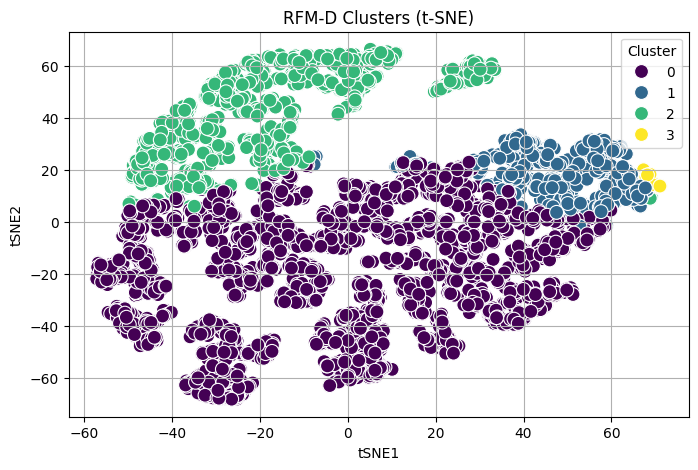

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from google.colab import files

# Завантаження файлу вручну
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# Очищення та підготовка даних
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df['PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)
df['Diversity'] = df.groupby(['CustomerID'])['Description'].transform('nunique')

# RFM-D таблиця
rfm_d = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                            # Frequency
    'TotalPrice': 'sum',                                               # Monetary
    'Diversity': 'mean'                                                # Diversity
}).reset_index()
rfm_d.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Diversity']

# Стандартизація
scaler = StandardScaler()
rfm_d_scaled = scaler.fit_transform(rfm_d[['Recency', 'Frequency', 'Monetary', 'Diversity']])

# PCA для зменшення вимірності
pca = PCA(n_components=2)
rfm_d_pca = pca.fit_transform(rfm_d_scaled)
rfm_d['PCA1'] = rfm_d_pca[:, 0]
rfm_d['PCA2'] = rfm_d_pca[:, 1]

# t-SNE для візуалізації
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
rfm_d_tsne = tsne.fit_transform(rfm_d_scaled)
rfm_d['tSNE1'] = rfm_d_tsne[:, 0]
rfm_d['tSNE2'] = rfm_d_tsne[:, 1]

# Визначення оптимального числа кластерів (Метод ліктя)
wcss = []
max_clusters = 10
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_d_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

# Оптимальна кластеризація
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_d['Cluster'] = kmeans.fit_predict(rfm_d_scaled)

# Візуалізація PCA
plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm_d, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100)
plt.title('RFM-D Clusters (PCA)')
plt.grid()
plt.show()

# Візуалізація t-SNE
plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm_d, x='tSNE1', y='tSNE2', hue='Cluster', palette='viridis', s=100)
plt.title('RFM-D Clusters (t-SNE)')
plt.grid()
plt.show()

# Збереження результатів
with pd.ExcelWriter('rfm_d_clusters.xlsx') as writer:
    rfm_d.to_excel(writer, sheet_name='RFM-D Clusters', index=False)

files.download('rfm_d_clusters.xlsx')



Ефективність дисконтування

Gradient Boosting

Saving Online Retail.xlsx to Online Retail (1).xlsx
Найкращі параметри: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}

Показники для тренувальних даних:
Mean Squared Error (Train): 0.003775
R² (Train): 0.999784
Mean Absolute Error (Train): 0.027673

Показники для тестових даних:
Mean Squared Error (Test): 0.054711
R² (Test): 0.997095
Mean Absolute Error (Test): 0.041024

Модель може бути перенавчена (overfitting).

Крос-валідація (MSE): 0.060206
Крос-валідація (R²): 0.996588

Вплив рівнів дисконту на показники Frequency, Monetary, Recency та Diversity:
                    Frequency     Monetary     Recency   Diversity
DiscountCategory                                                 
Low (10%)           1.833333    73.066970  247.893939    1.742424
Medium (15%)       36.131855   763.623050  138.822984   31.410484
High (20%)         91.099757  1602.305853   31.397810   70.592457
Very High (25%)   242.273673 

<ipython-input-2-0cb0c1352970>:137: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_impact = rfm.groupby('DiscountCategory')[['Frequency', 'Monetary', 'Recency', 'Diversity']].mean()
<ipython-input-2-0cb0c1352970>:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discount_impact.index, y=discount_impact['Frequency'], palette='viridis')
<ipython-input-2-0cb0c1352970>:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discount_impact.index, y=discount_impact['Monetary'], palette='viridis')
<

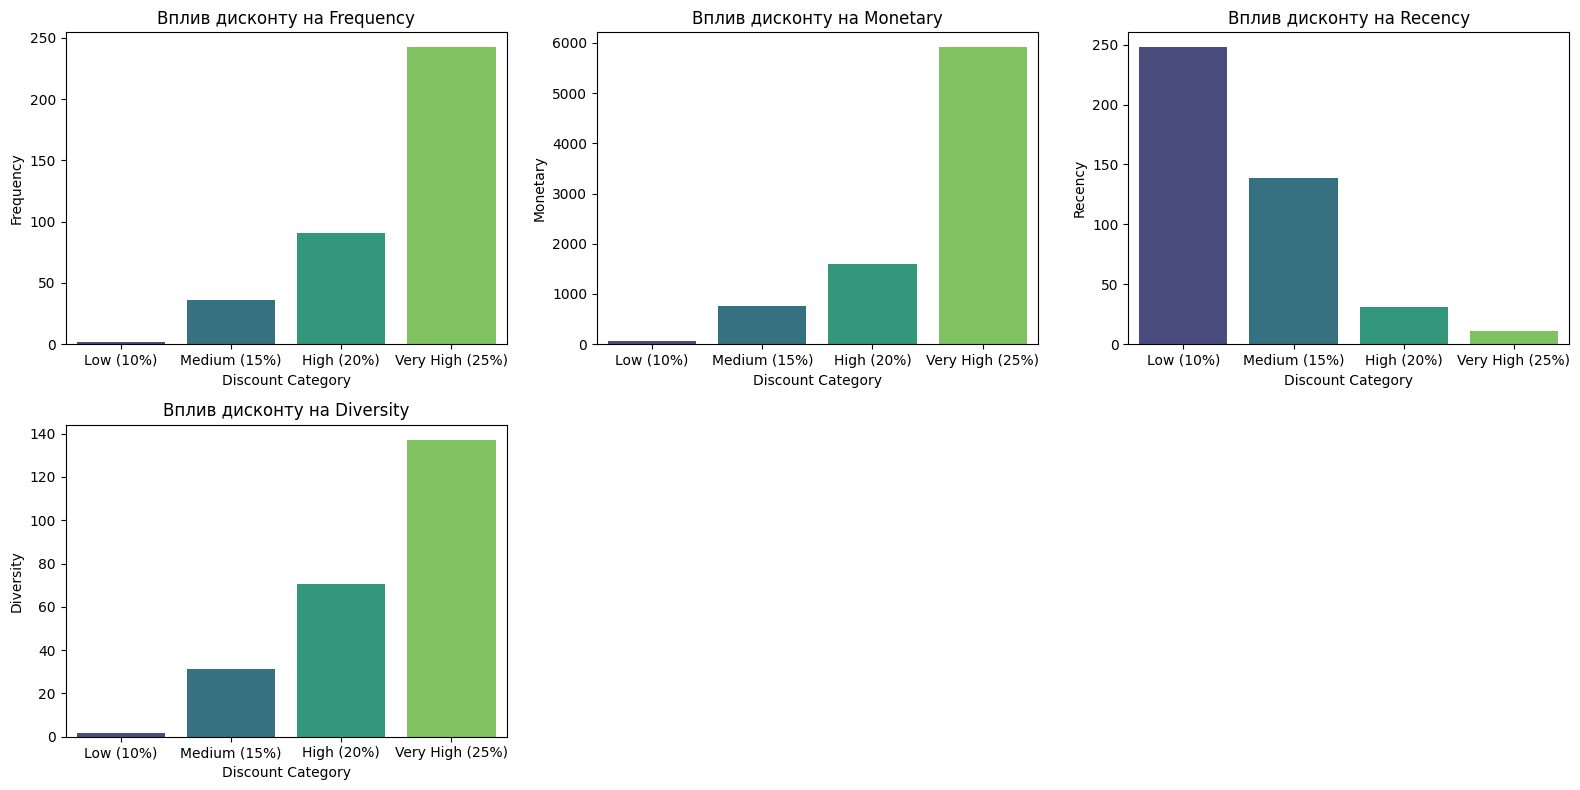

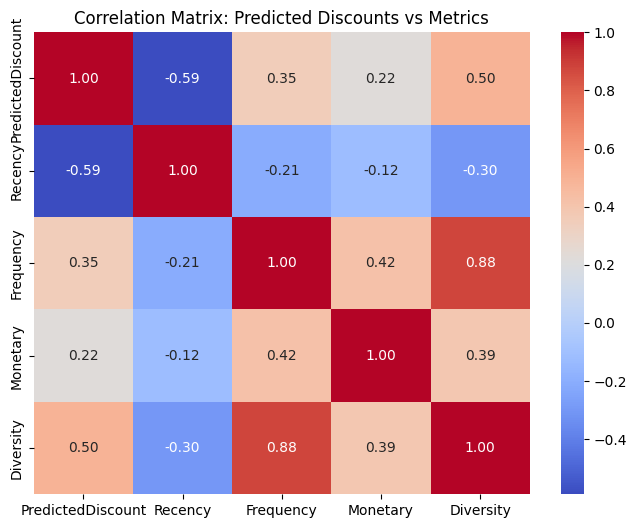

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

# Завантаження файлу вручну
uploaded = files.upload()

# Отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)

# Очищення даних: видалення відсутніх ID клієнтів і негативних значень кількості
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Перетворення InvoiceDate у формат datetime
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Додавання місяця першої покупки для кожного клієнта
df.loc[:, 'CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Додавання місяця кожної покупки
df.loc[:, 'PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')

# Розрахунок когортного індексу (номер місяця від першої покупки)
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# RFM-D аналіз
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

diversity = df.groupby('CustomerID')['Description'].nunique().reset_index()
diversity.rename(columns={'Description': 'Diversity'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')
rfm = pd.merge(rfm, diversity[['CustomerID', 'Diversity']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')

rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

# Функція для генерації знижок (0-25%)
def generate_discounts(row):
    if row['Frequency'] > 15 and row['Monetary'] > 1000 and row['Recency'] < 30 and row['Diversity'] > 10:
        return 25
    elif row['Frequency'] > 10 and row['Monetary'] > 500 and row['Recency'] < 60 and row['Diversity'] > 5:
        return 20
    elif row['Frequency'] > 5 or row['Monetary'] > 200 or row['Recency'] < 90 or row['Diversity'] > 3:
        return 15
    else:
        return 10

rfm['Discount'] = rfm.apply(generate_discounts, axis=1)

features = ['Recency', 'Frequency', 'Monetary', 'Diversity', 'CohortMonth']
X = rfm[features]
y = rfm['Discount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [50, 75, 100],       # Зменшено кількість дерев
    'learning_rate': [0.01, 0.05],      # Навчальна швидкість
    'max_depth': [3, 5],                # Обмежено глибину дерева
    'min_samples_split': [10, 15],      # Збільшено мін. кількість зразків для поділу
    'min_samples_leaf': [3, 5],         # Налаштовано мін. зразки в листі
    'subsample': [0.8]                  # Використано subsample для зменшення варіативності
}

model = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Найкращі параметри:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nПоказники для тренувальних даних:")
print(f"Mean Squared Error (Train): {train_mse:.6f}")
print(f"R² (Train): {train_r2:.6f}")
print(f"Mean Absolute Error (Train): {train_mae:.6f}")

print(f"\nПоказники для тестових даних:")
print(f"Mean Squared Error (Test): {test_mse:.6f}")
print(f"R² (Test): {test_r2:.6f}")
print(f"Mean Absolute Error (Test): {test_mae:.6f}")

if train_r2 > test_r2:
    print("\nМодель може бути перенавчена (overfitting).")
else:
    print("\nМодель не перенавчена.")

cv_scores = cross_val_score(best_model, scaler.fit_transform(X), y, cv=5, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(best_model, scaler.fit_transform(X), y, cv=5, scoring='r2')

print(f"\nКрос-валідація (MSE): {-cv_scores.mean():.6f}")
print(f"Крос-валідація (R²): {cv_r2_scores.mean():.6f}")

rfm['PredictedDiscount'] = best_model.predict(scaler.transform(rfm[features]))

# Аналіз ефективності дисконтування
rfm['DiscountCategory'] = pd.cut(rfm['PredictedDiscount'], bins=[0, 12, 17, 21, 25], labels=['Low (10%)', 'Medium (15%)', 'High (20%)', 'Very High (25%)'])

# Вплив дисконту на Frequency, Monetary, Recency та Diversity
discount_impact = rfm.groupby('DiscountCategory')[['Frequency', 'Monetary', 'Recency', 'Diversity']].mean()

print("\nВплив рівнів дисконту на показники Frequency, Monetary, Recency та Diversity:\n", discount_impact)

# Візуалізація впливу дисконту на показники
plt.figure(figsize=(16, 8))

# Frequency
plt.subplot(2, 3, 1)
sns.barplot(x=discount_impact.index, y=discount_impact['Frequency'], palette='viridis')
plt.title('Вплив дисконту на Frequency')
plt.xlabel('Discount Category')
plt.ylabel('Frequency')

# Monetary
plt.subplot(2, 3, 2)
sns.barplot(x=discount_impact.index, y=discount_impact['Monetary'], palette='viridis')
plt.title('Вплив дисконту на Monetary')
plt.xlabel('Discount Category')
plt.ylabel('Monetary')

# Recency
plt.subplot(2, 3, 3)
sns.barplot(x=discount_impact.index, y=discount_impact['Recency'], palette='viridis')
plt.title('Вплив дисконту на Recency')
plt.xlabel('Discount Category')
plt.ylabel('Recency')

# Diversity
plt.subplot(2, 3, 4)
sns.barplot(x=discount_impact.index, y=discount_impact['Diversity'], palette='viridis')
plt.title('Вплив дисконту на Diversity')
plt.xlabel('Discount Category')
plt.ylabel('Diversity')

plt.tight_layout()
plt.show()

# Аналіз кореляції між показниками
correlation_data = rfm[['PredictedDiscount', 'Recency', 'Frequency', 'Monetary', 'Diversity']]
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Predicted Discounts vs Metrics')
plt.show()

with pd.ExcelWriter('rfmd_cohort_analysis_gradient_boosting_updated.xlsx') as writer:
    rfm.to_excel(writer, sheet_name='RFM-D & Cohort Data')

files.download('rfmd_cohort_analysis_gradient_boosting_updated.xlsx')




XGBoost

Saving Online Retail.xlsx to Online Retail.xlsx


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:24:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-1-2e31c4dbee70>:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_impact = rfm.groupby('DiscountCategory')[['Frequency', 'Monetary', 'Recency', 'Diversity']].mean()


Результати крос-валідації:
   train-rmse-mean  train-rmse-std  train-mae-mean  train-mae-std  \
0         4.075497        0.023331        3.638152       0.027537   
1         3.872753        0.022090        3.457235       0.026143   
2         3.680057        0.021049        3.285317       0.024894   
3         3.497062        0.020056        3.122035       0.023724   
4         3.323289        0.019117        2.966936       0.022672   
5         3.158094        0.018170        2.819407       0.021507   
6         3.001094        0.017273        2.679306       0.020457   
7         2.852065        0.016330        2.546343       0.019426   
8         2.710248        0.015576        2.419765       0.018583   
9         2.575658        0.014867        2.299637       0.017723   

   test-rmse-mean  test-rmse-std  test-mae-mean  test-mae-std  
0        4.076770       0.092588       3.640157      0.072613  
1        3.874244       0.087681       3.459410      0.068512  
2        3.681780    

<ipython-input-1-2e31c4dbee70>:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discount_impact.index, y=discount_impact['Frequency'], palette='viridis')
<ipython-input-1-2e31c4dbee70>:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discount_impact.index, y=discount_impact['Monetary'], palette='viridis')
<ipython-input-1-2e31c4dbee70>:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discount_impact.index, y=discount_impact['Recency'], palette='viridis')
<ipython-input-1-2e31c4dbee70>:154: FutureWarning: 

Passing `palette` witho

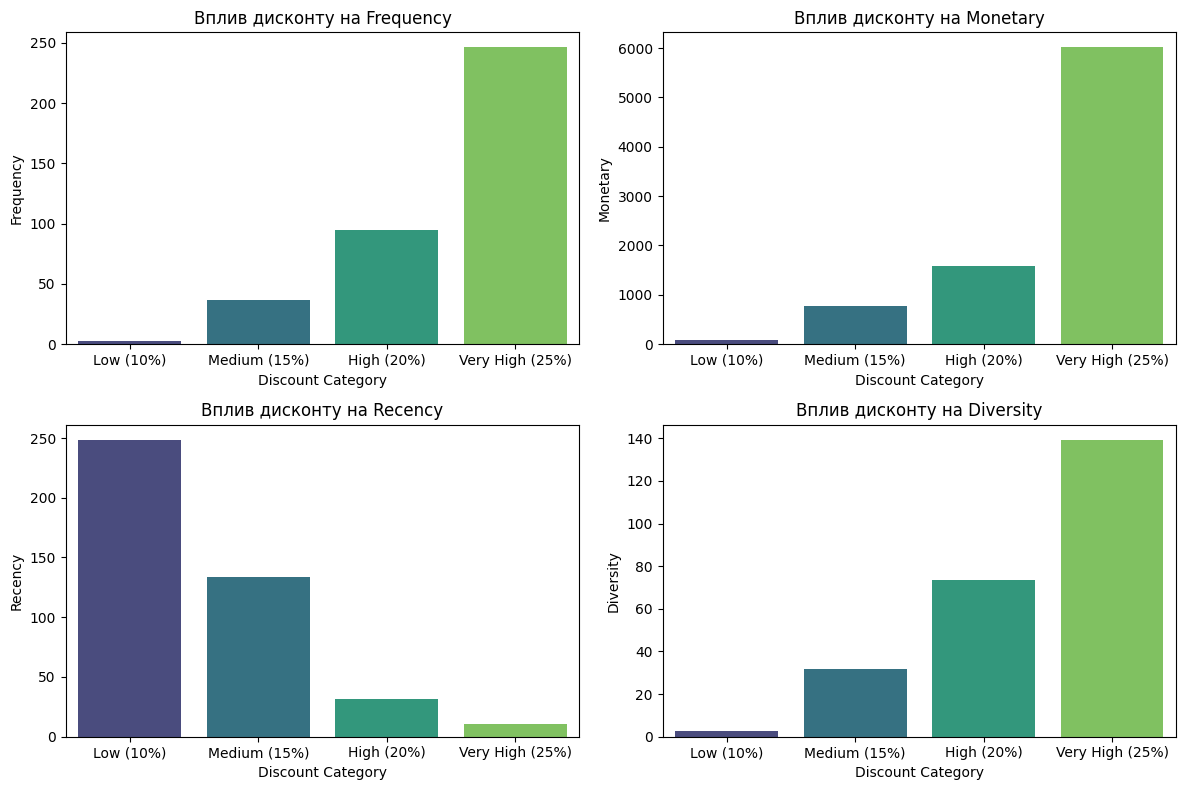

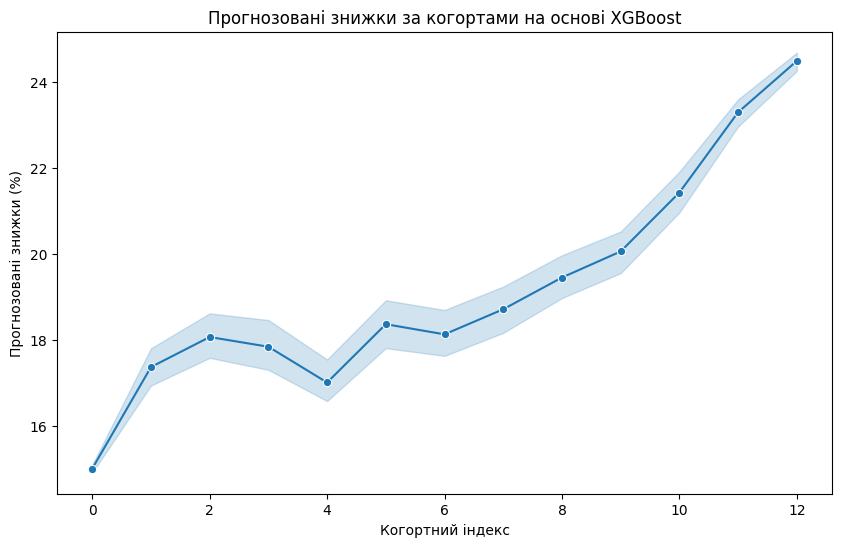

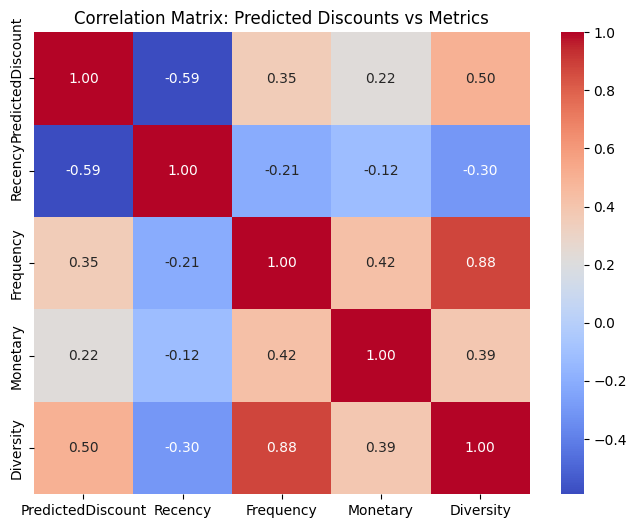

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from xgboost import XGBRegressor, cv, DMatrix
from xgboost.sklearn import XGBRegressor

# Завантаження файлу вручну
uploaded = files.upload()

# Отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)

# Очищення даних: видалення відсутніх ID клієнтів і негативних значень кількості
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Перетворення InvoiceDate у формат datetime
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Додавання місяця першої покупки для кожного клієнта
df.loc[:, 'CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Додавання місяця кожної покупки
df.loc[:, 'PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')

# Розрахунок когортного індексу (номер місяця від першої покупки)
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# RFM-D аналіз
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

diversity = df.groupby('CustomerID')['Description'].nunique().reset_index()
diversity.rename(columns={'Description': 'Diversity'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')
rfm = pd.merge(rfm, diversity[['CustomerID', 'Diversity']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')

rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

# Оновлена функція для генерації знижок (від 0 до 25%)
def generate_discounts(row):
    if row['Frequency'] > 15 and row['Monetary'] > 1000 and row['Recency'] < 30 and row['Diversity'] > 5:
        return 25
    elif row['Frequency'] > 10 and row['Monetary'] > 500 and row['Recency'] < 60:
        return 20
    elif row['Frequency'] > 5 or row['Monetary'] > 200 or row['Recency'] < 90:
        return 15
    else:
        return 10

rfm['Discount'] = rfm.apply(generate_discounts, axis=1)

features = ['Recency', 'Frequency', 'Monetary', 'Diversity', 'CohortMonth']
X = rfm[features]
y = rfm['Discount']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ручне налаштування параметрів моделі
model = XGBRegressor(
    n_estimators=100,      # Кількість дерев
    learning_rate=0.05,    # Навчальна швидкість
    max_depth=5,           # Максимальна глибина дерева
    min_child_weight=3,    # Мінімальна вага кожної листової одиниці
    subsample=0.8,         # Частина зразків, що використовуються для тренування
    random_state=42
)

# Використання вбудованої функції крос-валідації
dmatrix = DMatrix(X_scaled, label=y)
cv_results = cv(
    dtrain=dmatrix,
    params=model.get_params(),
    nfold=5,
    metrics=('rmse', 'mae'),
    as_pandas=True,
    seed=42
)

print("Результати крос-валідації:")
print(cv_results)

# Навчання моделі
model.fit(X_scaled, y)

# Прогнозування
y_pred = model.predict(X_scaled)

# Оцінка моделі
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"\nПоказники моделі:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R²: {r2:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")

rfm['PredictedDiscount'] = y_pred

# Аналіз ефективності дисконтування
rfm['DiscountCategory'] = pd.cut(rfm['PredictedDiscount'], bins=[0, 12, 17, 21, 25], labels=['Low (10%)', 'Medium (15%)', 'High (20%)', 'Very High (25%)'])

# Вплив дисконту на Frequency, Monetary, Recency, Diversity
discount_impact = rfm.groupby('DiscountCategory')[['Frequency', 'Monetary', 'Recency', 'Diversity']].mean()

print("\nВплив рівнів дисконту на показники Frequency, Monetary, Recency та Diversity:\n", discount_impact)

# Візуалізація впливу дисконту на показники
plt.figure(figsize=(12, 8))

# Вплив на Frequency та Monetary
plt.subplot(2, 2, 1)
sns.barplot(x=discount_impact.index, y=discount_impact['Frequency'], palette='viridis')
plt.title('Вплив дисконту на Frequency')
plt.xlabel('Discount Category')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.barplot(x=discount_impact.index, y=discount_impact['Monetary'], palette='viridis')
plt.title('Вплив дисконту на Monetary')
plt.xlabel('Discount Category')
plt.ylabel('Monetary')

# Вплив на Recency та Diversity
plt.subplot(2, 2, 3)
sns.barplot(x=discount_impact.index, y=discount_impact['Recency'], palette='viridis')
plt.title('Вплив дисконту на Recency')
plt.xlabel('Discount Category')
plt.ylabel('Recency')

plt.subplot(2, 2, 4)
sns.barplot(x=discount_impact.index, y=discount_impact['Diversity'], palette='viridis')
plt.title('Вплив дисконту на Diversity')
plt.xlabel('Discount Category')
plt.ylabel('Diversity')

plt.tight_layout()
plt.show()

# Візуалізація прогнозованих знижок
plt.figure(figsize=(10, 6))
sns.lineplot(x='CohortIndex', y='PredictedDiscount', data=rfm, marker='o')
plt.title('Прогнозовані знижки за когортами на основі XGBoost')
plt.xlabel('Когортний індекс')
plt.ylabel('Прогнозовані знижки (%)')
plt.show()

# Аналіз кореляції між показниками
correlation_data = rfm[['PredictedDiscount', 'Recency', 'Frequency', 'Monetary', 'Diversity']]
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Predicted Discounts vs Metrics')
plt.show()

# Збереження результатів в Excel
with pd.ExcelWriter('rfmd_cohort_analysis_xgboost_v2.xlsx') as writer:
    rfm.to_excel(writer, sheet_name='RFM-D & Cohort Data')

# Завантаження файлу
files.download('rfmd_cohort_analysis_xgboost_v2.xlsx')



LightGBM

Saving Online Retail.xlsx to Online Retail (3).xlsx


<ipython-input-8-b69b428a48e8>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 3471, number of used features: 5
[LightGBM] [Info] Start training from score 14.487179
Найкращі параметри (LightGBM): {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 10, 'n_estimators': 100, 'num_leaves': 15, 'subsample': 0.8}

Показники для тренувальних даних (LightGBM):
Mean Squared Error (Train): 0.064926
R² (Train): 0.999069
Mean Absolute Error (Train): 0.091866

Показники для тестових даних (LightGBM):
Mean Squared Error (Test): 0.164394
R² (Test): 0.997709
Mean Absolute Error (Test): 0.113645

Модель може бути перенавчена (overfitting).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhe

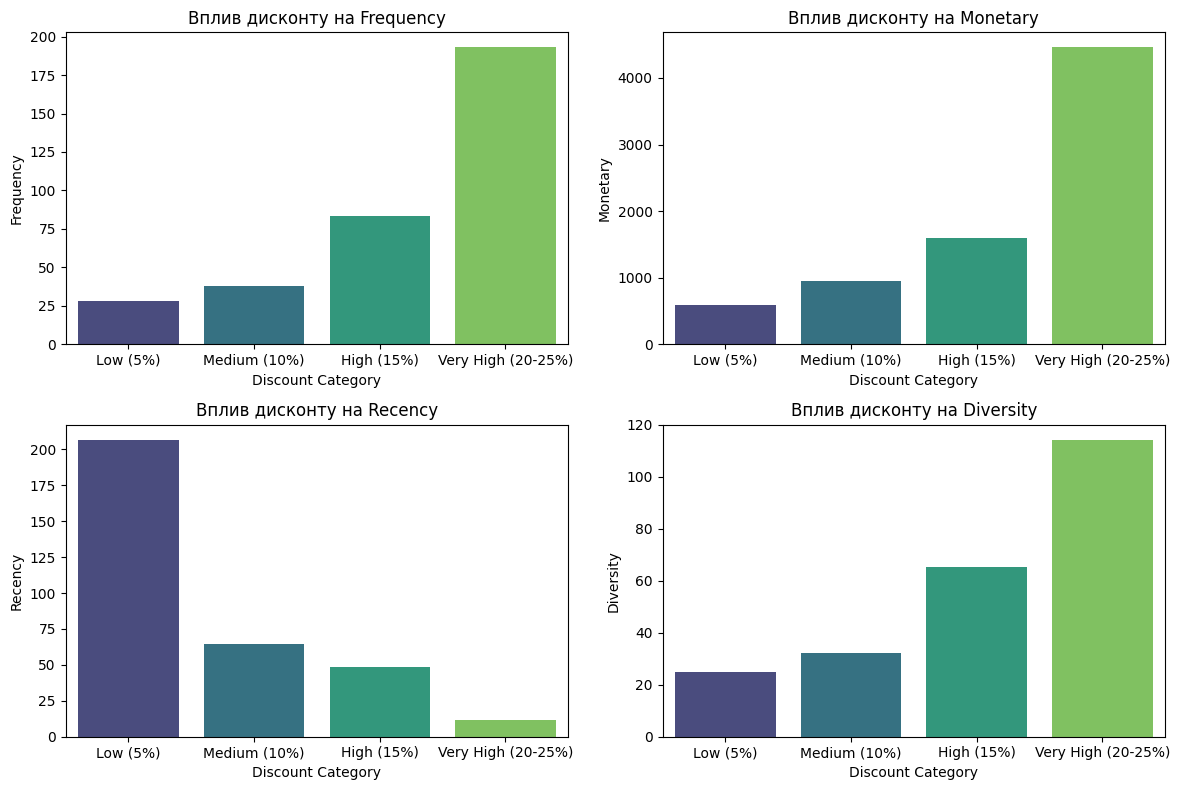

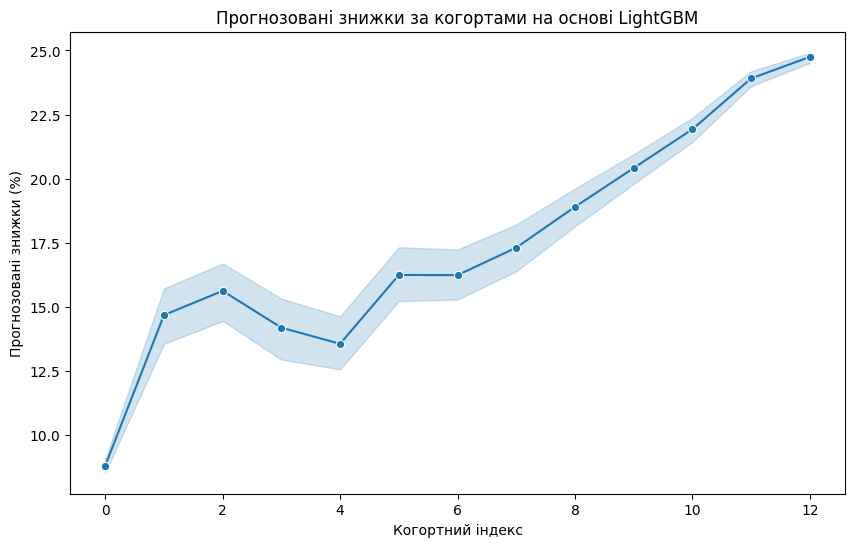

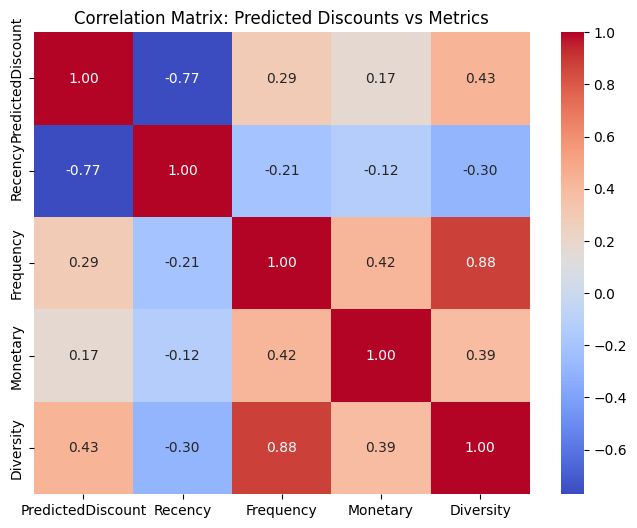

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import lightgbm as lgb
import warnings

# Ігнорування FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Завантаження файлу вручну
uploaded = files.upload()

# Отримуємо ім'я файлу
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)

# Очищення даних: видалення відсутніх ID клієнтів і негативних значень кількості
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]

# Обчислення TotalPrice
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Перетворення InvoiceDate у формат datetime
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Додавання місяця першої покупки для кожного клієнта
df.loc[:, 'CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Додавання місяця кожної покупки
df.loc[:, 'PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')

# Розрахунок когортного індексу (номер місяця від першої покупки)
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# RFM-D аналіз
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

diversity = df.groupby('CustomerID')['Description'].nunique().reset_index()
diversity.rename(columns={'Description': 'Diversity'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')
rfm = pd.merge(rfm, diversity[['CustomerID', 'Diversity']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')

rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

# Функція для генерації знижок з урахуванням усіх характеристик RFM-D
def generate_discounts(row):
    if row['Recency'] < 30 and row['Frequency'] > 10 and row['Monetary'] > 500 and row['Diversity'] > 5:
        return 25
    elif row['Recency'] < 60 and row['Frequency'] > 8 and row['Monetary'] > 400 and row['Diversity'] > 4:
        return 20
    elif row['Recency'] < 90 and row['Frequency'] > 5 and row['Monetary'] > 300 and row['Diversity'] > 3:
        return 15
    elif row['Recency'] < 120 and row['Frequency'] > 3 and row['Monetary'] > 200 and row['Diversity'] > 2:
        return 10
    else:
        return 5

rfm['Discount'] = rfm.apply(generate_discounts, axis=1)

# Вибір ознак та цільової змінної
features = ['Recency', 'Frequency', 'Monetary', 'Diversity', 'CohortMonth']
X = rfm[features]
y = rfm['Discount']

# Розбиття на тренувальні та тестові набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизація даних
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Параметри для GridSearchCV
param_grid_lgb = {
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, -1],
    'num_leaves': [15, 31],
    'min_child_samples': [10, 20],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

# Ініціалізація моделі LightGBM
model_lgb = lgb.LGBMRegressor(random_state=42)

# Налаштування GridSearchCV для LightGBM
grid_search_lgb = GridSearchCV(estimator=model_lgb, param_grid=param_grid_lgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lgb.fit(X_train_scaled, y_train)

# Найкращі параметри
print("Найкращі параметри (LightGBM):", grid_search_lgb.best_params_)

# Найкраща модель LightGBM
best_model_lgb = grid_search_lgb.best_estimator_

# Прогнози
y_pred_train_lgb = best_model_lgb.predict(X_train_scaled)
y_pred_test_lgb = best_model_lgb.predict(X_test_scaled)

# Метрики
train_mse_lgb = mean_squared_error(y_train, y_pred_train_lgb)
test_mse_lgb = mean_squared_error(y_test, y_pred_test_lgb)
train_r2_lgb = r2_score(y_train, y_pred_train_lgb)
test_r2_lgb = r2_score(y_test, y_pred_test_lgb)
train_mae_lgb = mean_absolute_error(y_train, y_pred_train_lgb)
test_mae_lgb = mean_absolute_error(y_test, y_pred_test_lgb)

# Виведення результатів
print(f"\nПоказники для тренувальних даних (LightGBM):")
print(f"Mean Squared Error (Train): {train_mse_lgb:.6f}")
print(f"R² (Train): {train_r2_lgb:.6f}")
print(f"Mean Absolute Error (Train): {train_mae_lgb:.6f}")

print(f"\nПоказники для тестових даних (LightGBM):")
print(f"Mean Squared Error (Test): {test_mse_lgb:.6f}")
print(f"R² (Test): {test_r2_lgb:.6f}")
print(f"Mean Absolute Error (Test): {test_mae_lgb:.6f}")

# Перевірка на перенавчання
if train_r2_lgb > test_r2_lgb:
    print("\nМодель може бути перенавчена (overfitting).")
else:
    print("\nМодель не перенавчена.")

# Крос-валідація
cv_scores_lgb = cross_val_score(best_model_lgb, scaler.fit_transform(X), y, cv=5, scoring='neg_mean_squared_error')
cv_r2_scores_lgb = cross_val_score(best_model_lgb, scaler.fit_transform(X), y, cv=5, scoring='r2')

print(f"\nКрос-валідація (MSE, LightGBM): {-cv_scores_lgb.mean():.6f}")
print(f"Крос-валідація (R², LightGBM): {cv_r2_scores_lgb.mean():.6f}")

# Прогноз для всього набору даних
rfm['PredictedDiscount'] = best_model_lgb.predict(scaler.transform(rfm[features]))

# Аналіз ефективності дисконтування
rfm['DiscountCategory'] = pd.cut(rfm['PredictedDiscount'], bins=[0, 7, 15, 20, 25], labels=['Low (5%)', 'Medium (10%)', 'High (15%)', 'Very High (20-25%)'])

# Вплив дисконту на Frequency, Monetary, Recency та Diversity
discount_impact = rfm.groupby('DiscountCategory')[['Frequency', 'Monetary', 'Recency', 'Diversity']].mean()

print("\nВплив рівнів дисконту на показники Frequency, Monetary, Recency та Diversity:\n", discount_impact)

# Візуалізація впливу дисконту на показники
plt.figure(figsize=(12, 8))

# Frequency
plt.subplot(2, 2, 1)
sns.barplot(x=discount_impact.index, y=discount_impact['Frequency'], palette='viridis')
plt.title('Вплив дисконту на Frequency')
plt.xlabel('Discount Category')
plt.ylabel('Frequency')

# Monetary
plt.subplot(2, 2, 2)
sns.barplot(x=discount_impact.index, y=discount_impact['Monetary'], palette='viridis')
plt.title('Вплив дисконту на Monetary')
plt.xlabel('Discount Category')
plt.ylabel('Monetary')

# Recency
plt.subplot(2, 2, 3)
sns.barplot(x=discount_impact.index, y=discount_impact['Recency'], palette='viridis')
plt.title('Вплив дисконту на Recency')
plt.xlabel('Discount Category')
plt.ylabel('Recency')

# Diversity
plt.subplot(2, 2, 4)
sns.barplot(x=discount_impact.index, y=discount_impact['Diversity'], palette='viridis')
plt.title('Вплив дисконту на Diversity')
plt.xlabel('Discount Category')
plt.ylabel('Diversity')

plt.tight_layout()
plt.show()

# Візуалізація прогнозованих знижок
plt.figure(figsize=(10, 6))
sns.lineplot(x='CohortIndex', y='PredictedDiscount', data=rfm, marker='o')
plt.title('Прогнозовані знижки за когортами на основі LightGBM')
plt.xlabel('Когортний індекс')
plt.ylabel('Прогнозовані знижки (%)')
plt.show()

correlation_data = rfm[['PredictedDiscount', 'Recency', 'Frequency', 'Monetary', 'Diversity']]
correlation_matrix = correlation_data.corr()

# Візуалізація кореляційної матриці
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Predicted Discounts vs Metrics')
plt.show()

# Збереження результатів в Excel
with pd.ExcelWriter('rfmd_cohort_analysis_lightgbm.xlsx') as writer:
    rfm.to_excel(writer, sheet_name='RFM-D & Cohort Data')

# Завантаження файлу
files.download('rfmd_cohort_analysis_lightgbm.xlsx')



Прибутковість

Gradient Boosting

Saving Online Retail.xlsx to Online Retail.xlsx
Оптимальні рівні дисконту для кожної когорти:
     CohortMonth  Discount         Profit
0         24132         0  975519.272736
1         24133         0  309329.664181
2         24134         0  125248.798501
3         24135         0  107996.876760
4         24136         0   69846.092918
5         24137         0   88571.992774
6         24138         0   64763.746331
7         24139         0   43057.647807
8         24140         0   89296.666484
9         24141         0   37032.194123
10        24142         0   28812.370862
11        24143         0   17841.638416
12        24144         0   15839.683902


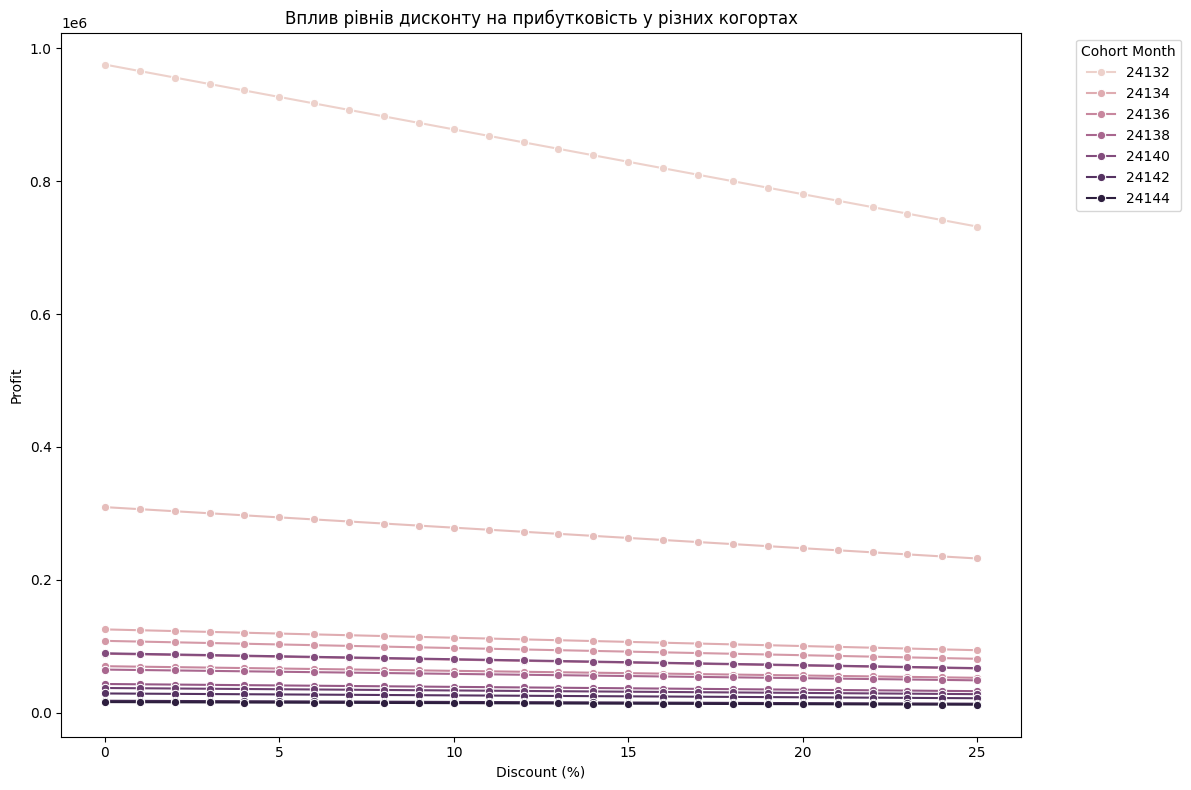

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
import numpy as np

# Завантаження файлу вручну
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# Очищення даних
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.loc[:, 'CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df.loc[:, 'PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# RFM-D аналіз
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

diversity = df.groupby('CustomerID')['Description'].nunique().reset_index()
diversity.rename(columns={'Description': 'Diversity'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')
rfm = pd.merge(rfm, diversity[['CustomerID', 'Diversity']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')
rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

# Генерація знижок від 0% до 25% з кроком 1%
discount_levels = np.arange(0, 26, 1)
cohort_analysis = []

for discount in discount_levels:
    rfm['TestDiscount'] = discount
    rfm['AdjustedMonetary'] = rfm['Monetary'] * (1 - discount / 100)
    cohort_summary = rfm.groupby('CohortMonth')[['Frequency', 'AdjustedMonetary']].mean().reset_index()
    cohort_summary['Profit'] = cohort_summary['AdjustedMonetary'] * cohort_summary['Frequency']
    cohort_summary['Discount'] = discount
    cohort_analysis.append(cohort_summary)

cohort_analysis = pd.concat(cohort_analysis, ignore_index=True)

# Визначення оптимального рівня дисконту
optimal_discounts = cohort_analysis.loc[cohort_analysis.groupby('CohortMonth')['Profit'].idxmax()]
print("Оптимальні рівні дисконту для кожної когорти:\n", optimal_discounts[['CohortMonth', 'Discount', 'Profit']])

# Візуалізація впливу дисконту на прибуток
plt.figure(figsize=(12, 8))
sns.lineplot(data=cohort_analysis, x='Discount', y='Profit', hue='CohortMonth', marker='o')
plt.title('Вплив рівнів дисконту на прибутковість у різних когортах')
plt.xlabel('Discount (%)')
plt.ylabel('Profit')
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Експорт результатів
optimal_discounts.to_excel('optimal_discounts_per_cohort_gradient_boost.xlsx', index=False)
files.download('optimal_discounts_per_cohort_gradient_boost.xlsx')



XGBoost

Saving Online Retail.xlsx to Online Retail (1).xlsx

Показники моделі:
Mean Squared Error (MSE): 0.014747
R²: 0.991752
Mean Absolute Error (MAE): 0.036643
Оптимальні рівні дисконту для кожної когорти:
     CohortMonth  Discount         Profit
0         24132       0.0  975519.272736
1         24133       0.0  309329.664181
2         24134       0.0  125248.798501
3         24135       0.0  107996.876760
4         24136       0.0   69846.092918
5         24137       0.0   88571.992774
6         24138       0.0   64763.746331
7         24139       0.0   43057.647807
8         24140       0.0   89296.666484
9         24141       0.0   37032.194123
10        24142       0.0   28812.370862
11        24143       0.0   17841.638416
12        24144       0.0   15839.683902


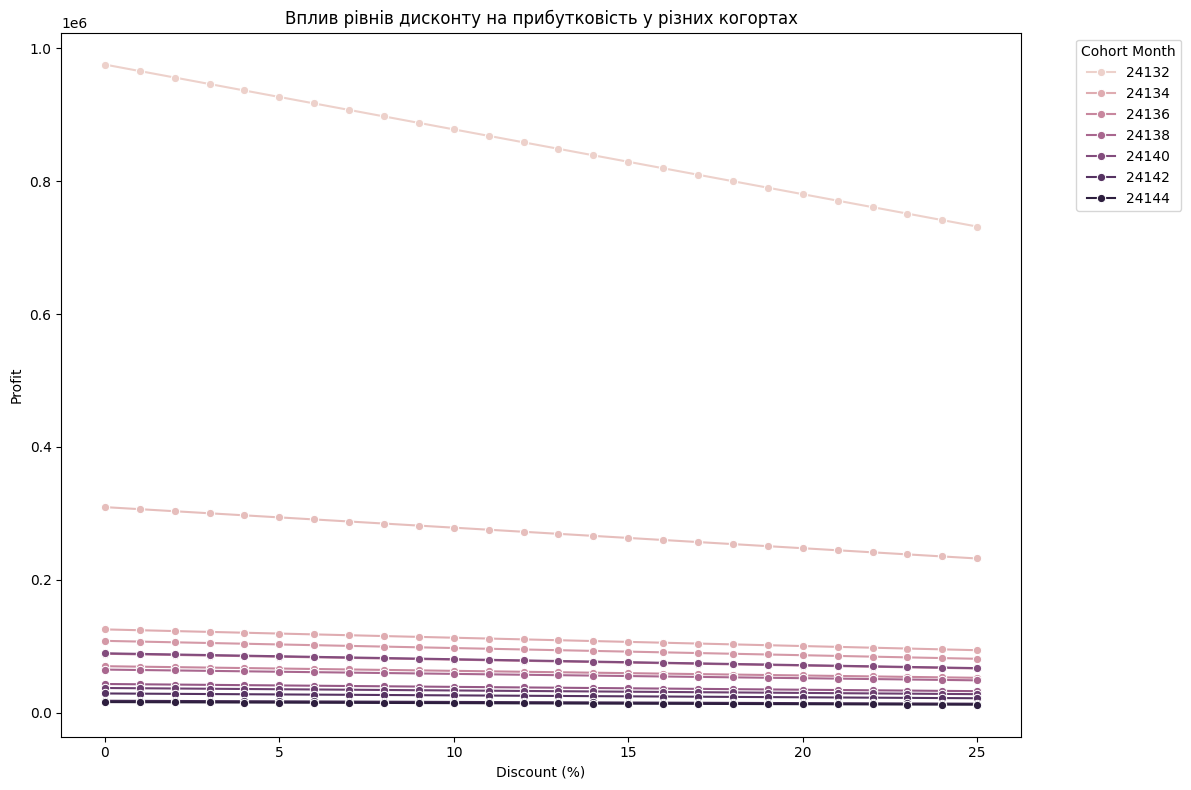

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from xgboost import XGBRegressor

# Завантаження файлу вручну
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# Очищення даних
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.loc[:, 'CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df.loc[:, 'PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# RFM-D аналіз
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

diversity = df.groupby('CustomerID')['Description'].nunique().reset_index()
diversity.rename(columns={'Description': 'Diversity'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')
rfm = pd.merge(rfm, diversity[['CustomerID', 'Diversity']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')
rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

# Генерація початкових знижок на основі всіх RFM-D характеристик
def generate_discounts(row):
    score = (
        (1 / (1 + row['Recency'])) * 0.25 +
        (row['Frequency'] / rfm['Frequency'].max()) * 0.25 +
        (row['Monetary'] / rfm['Monetary'].max()) * 0.25 +
        (row['Diversity'] / rfm['Diversity'].max()) * 0.25
    )
    return round(score * 25, 1)  # Від 0 до 25% з кроком 0.1%

rfm['Discount'] = rfm.apply(generate_discounts, axis=1)

# Машинне навчання
features = ['Recency', 'Frequency', 'Monetary', 'Diversity', 'CohortMonth']
X = rfm[features]
y = rfm['Discount']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, min_child_weight=3, subsample=0.8, random_state=42)
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)

# Оцінка моделі
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
print(f"\nПоказники моделі:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R²: {r2:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")

rfm['PredictedDiscount'] = y_pred

# Оптимізація дисконту
discount_levels = np.arange(0, 25.1, 1)  # Від 0 до 25% з кроком 1%
cohort_analysis = []
for discount in discount_levels:
    rfm['TestDiscount'] = discount
    rfm['AdjustedMonetary'] = rfm['Monetary'] * (1 - discount / 100)
    cohort_summary = rfm.groupby('CohortMonth')[['Frequency', 'AdjustedMonetary']].mean().reset_index()
    cohort_summary['Profit'] = cohort_summary['AdjustedMonetary'] * cohort_summary['Frequency']
    cohort_summary['Discount'] = discount
    cohort_analysis.append(cohort_summary)

cohort_analysis = pd.concat(cohort_analysis, ignore_index=True)
optimal_discounts = cohort_analysis.loc[cohort_analysis.groupby('CohortMonth')['Profit'].idxmax()]
print("Оптимальні рівні дисконту для кожної когорти:\n", optimal_discounts[['CohortMonth', 'Discount', 'Profit']])

# Візуалізація
plt.figure(figsize=(12, 8))
sns.lineplot(data=cohort_analysis, x='Discount', y='Profit', hue='CohortMonth', marker='o')
plt.title('Вплив рівнів дисконту на прибутковість у різних когортах')
plt.xlabel('Discount (%)')
plt.ylabel('Profit')
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Збереження
optimal_discounts.to_excel('optimal_discounts_per_cohort_XGBOOST.xlsx', index=False)
files.download('optimal_discounts_per_cohort_XGBOOST.xlsx')



LightGBM

Saving Online Retail.xlsx to Online Retail (2).xlsx
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 4339, number of used features: 5
[LightGBM] [Info] Start training from score 0.796266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

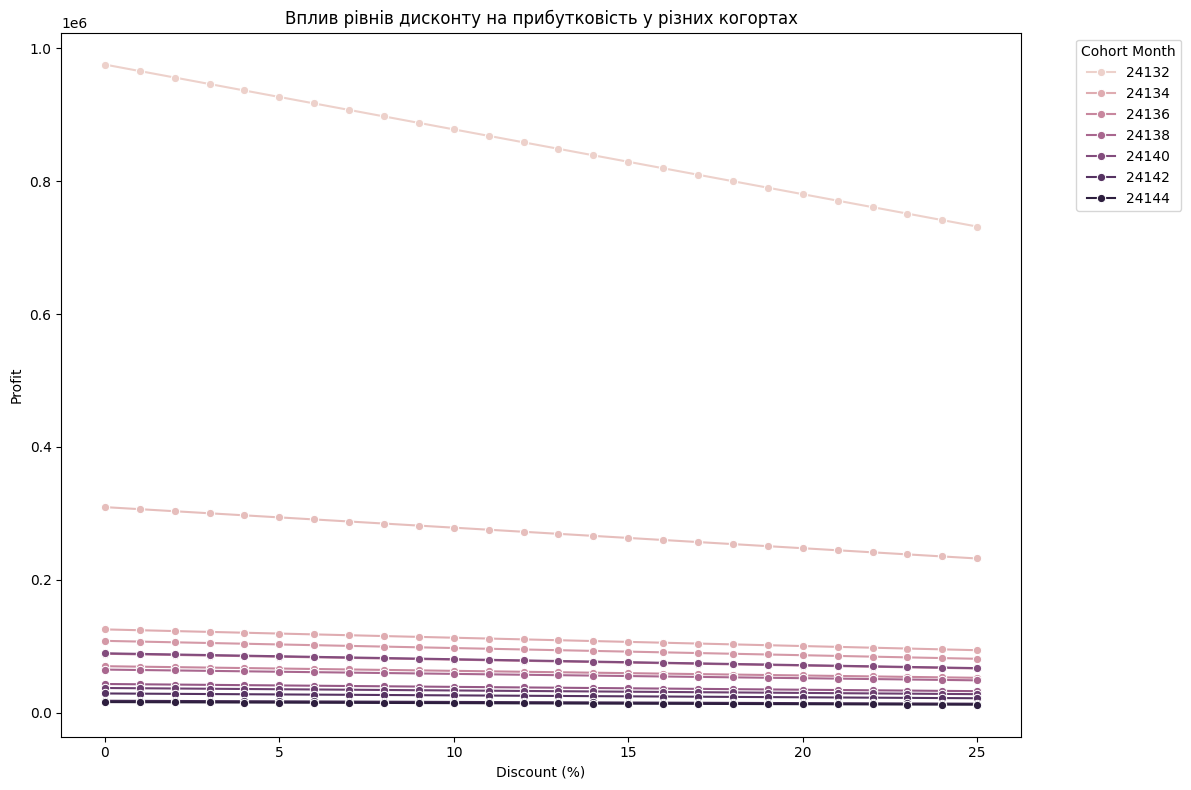

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import lightgbm as lgb

# Завантаження файлу вручну
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# Очищення даних
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.loc[:, 'CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df.loc[:, 'PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# RFM-D аналіз
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

diversity = df.groupby('CustomerID')['Description'].nunique().reset_index()
diversity.rename(columns={'Description': 'Diversity'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')
rfm = pd.merge(rfm, diversity[['CustomerID', 'Diversity']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')
rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

# Генерація початкових знижок
def generate_discounts(row):
    score = (
        (1 / (1 + row['Recency'])) * 0.25 +
        (row['Frequency'] / rfm['Frequency'].max()) * 0.25 +
        (row['Monetary'] / rfm['Monetary'].max()) * 0.25 +
        (row['Diversity'] / rfm['Diversity'].max()) * 0.25
    )
    return round(score * 25, 1)

rfm['Discount'] = rfm.apply(generate_discounts, axis=1)

# Машинне навчання
features = ['Recency', 'Frequency', 'Monetary', 'Diversity', 'CohortMonth']
X = rfm[features]
y = rfm['Discount']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, num_leaves=31, subsample=0.8, random_state=42)
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)

# Оцінка моделі
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
print(f"\nПоказники моделі:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R²: {r2:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")

rfm['PredictedDiscount'] = y_pred

# Оптимізація дисконту
discount_levels = np.arange(0, 25.1, 1)
cohort_analysis = []
for discount in discount_levels:
    rfm['TestDiscount'] = discount
    rfm['AdjustedMonetary'] = rfm['Monetary'] * (1 - discount / 100)
    cohort_summary = rfm.groupby('CohortMonth')[['Frequency', 'AdjustedMonetary']].mean().reset_index()
    cohort_summary['Profit'] = cohort_summary['AdjustedMonetary'] * cohort_summary['Frequency']
    cohort_summary['Discount'] = discount
    cohort_analysis.append(cohort_summary)

cohort_analysis = pd.concat(cohort_analysis, ignore_index=True)
optimal_discounts = cohort_analysis.loc[cohort_analysis.groupby('CohortMonth')['Profit'].idxmax()]
print("Оптимальні рівні дисконту для кожної когорти:\n", optimal_discounts[['CohortMonth', 'Discount', 'Profit']])

# Візуалізація
plt.figure(figsize=(12, 8))
sns.lineplot(data=cohort_analysis, x='Discount', y='Profit', hue='CohortMonth', marker='o')
plt.title('Вплив рівнів дисконту на прибутковість у різних когортах')
plt.xlabel('Discount (%)')
plt.ylabel('Profit')
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Збереження
optimal_discounts.to_excel('optimal_discounts_per_cohort_LightGBM.xlsx', index=False)
files.download('optimal_discounts_per_cohort_LightGBM.xlsx')



Вплив рівнів дисконту на показники Frequency, Recency, Monetary та Diversity

Saving Online Retail.xlsx to Online Retail (1).xlsx


Training Episodes: 100%|██████████| 50/50 [54:12<00:00, 65.05s/it] 
<ipython-input-2-f7f5d2fcef7d>:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_impact = rfm.groupby('DiscountCategory')[['Recency', 'Frequency', 'Monetary', 'Diversity']].mean()
<ipython-input-2-f7f5d2fcef7d>:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discount_impact.index, y=discount_impact['Recency'], palette='viridis')
<ipython-input-2-f7f5d2fcef7d>:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discount

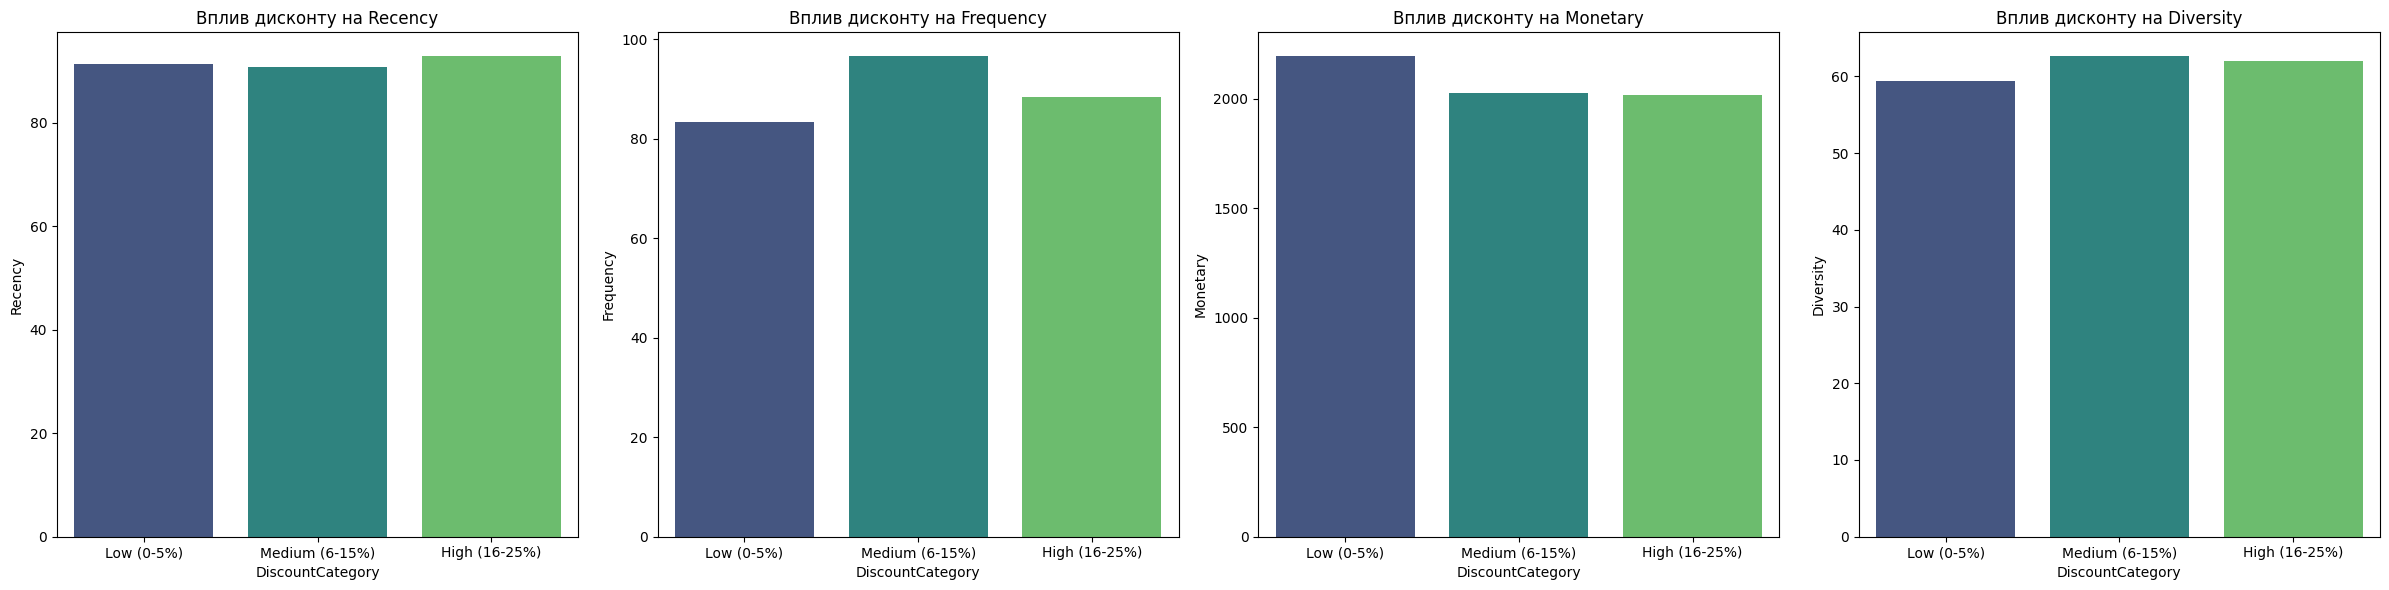

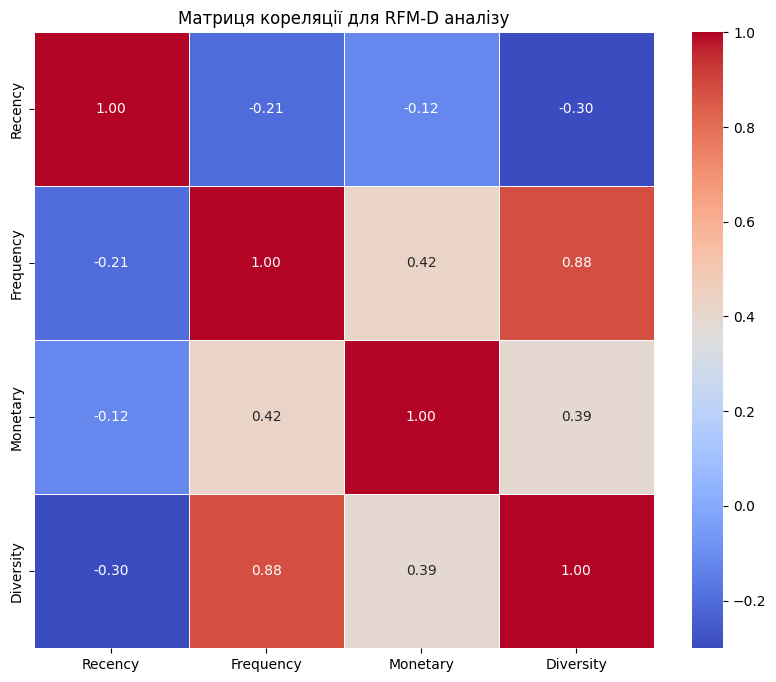

                  Diversity  Frequency     Monetary
DiscountCategory                                   
Low (0-5%)        59.378882  83.443478  2194.594857
Medium (6-15%)    62.599371  96.599820  2024.901502
High (16-25%)     62.041221  88.483969  2016.319163


<ipython-input-2-f7f5d2fcef7d>:155: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  discount_impact_table = pd.pivot_table(rfm, values=['Frequency', 'Monetary', 'Diversity'],


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import files
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from collections import deque
import random

# Завантаження файлу вручну
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# RFM-D Аналіз
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df['PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

diversity = df.groupby('CustomerID')['Description'].nunique().reset_index()
diversity.rename(columns={'Description': 'Diversity'}, inplace=True)

rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID').merge(diversity, on='CustomerID')

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.995, exploration_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.exploration_min = exploration_min
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Input(shape=(self.state_size,)),
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randint(0, self.action_size - 1)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.discount_factor * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

# Підготовка даних
state_size = 4  # Recency, Frequency, Monetary, Diversity
action_size = 26  # Діапазон знижок 0% - 25% (крок 1%)
agent = DQNAgent(state_size, action_size)

rfm_states = rfm[['Recency', 'Frequency', 'Monetary', 'Diversity']].values
scaler = StandardScaler()
rfm_states = scaler.fit_transform(rfm_states)

# Навчання агента
n_episodes = 50
batch_size = 32

for episode in tqdm(range(n_episodes), desc="Training Episodes"):
    for idx in range(len(rfm)):
        state = np.reshape(rfm_states[idx], [1, state_size])
        action = agent.act(state)
        discount = action * 0.01
        reward = -rfm.iloc[idx]['Recency'] + rfm.iloc[idx]['Monetary'] * (1 - discount)
        next_state = state
        done = True
        agent.remember(state, action, reward, next_state, done)
    agent.replay(batch_size)

# Застосування політики агента
rfm['PredictedDiscount'] = rfm.apply(lambda row: agent.act(np.reshape(scaler.transform([[row['Recency'], row['Frequency'], row['Monetary'], row['Diversity']]]), [1, state_size])) * 1, axis=1)

# Аналіз впливу дисконту
rfm['DiscountCategory'] = pd.cut(rfm['PredictedDiscount'], bins=[-1, 5, 15, 25], labels=['Low (0-5%)', 'Medium (6-15%)', 'High (16-25%)'])

discount_impact = rfm.groupby('DiscountCategory')[['Recency', 'Frequency', 'Monetary', 'Diversity']].mean()

# Візуалізація
plt.figure(figsize=(24, 6))

plt.subplot(1, 4, 1)
sns.barplot(x=discount_impact.index, y=discount_impact['Recency'], palette='viridis')
plt.title('Вплив дисконту на Recency')

plt.subplot(1, 4, 2)
sns.barplot(x=discount_impact.index, y=discount_impact['Frequency'], palette='viridis')
plt.title('Вплив дисконту на Frequency')

plt.subplot(1, 4, 3)
sns.barplot(x=discount_impact.index, y=discount_impact['Monetary'], palette='viridis')
plt.title('Вплив дисконту на Monetary')

plt.subplot(1, 4, 4)
sns.barplot(x=discount_impact.index, y=discount_impact['Diversity'], palette='viridis')
plt.title('Вплив дисконту на Diversity')

plt.tight_layout()
plt.show()

# Додавання матриці кореляції
correlation_matrix = rfm[['Recency', 'Frequency', 'Monetary', 'Diversity']].corr()

# Виведення матриці кореляції
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матриця кореляції для RFM-D аналізу')
plt.show()

# Вплив рівнів дисконту на показники Frequency, Recency, Monetary та Diversity
discount_impact_table = pd.pivot_table(rfm, values=['Frequency', 'Monetary', 'Diversity'],
                                      index='DiscountCategory',
                                      aggfunc={'Frequency': 'mean', 'Monetary': 'mean', 'Diversity': 'mean'})

# Виведення таблиці
print(discount_impact_table)

# Додавання результату у файл для збереження
discount_impact_table.to_excel('discount_impact_table.xlsx', index=True)
files.download('discount_impact_table.xlsx')

# Збереження основного результату
rfm.to_excel('rfm_dqn_discount_analysis.xlsx', index=False)
files.download('rfm_dqn_discount_analysis.xlsx')



Прибутковість

Saving Online Retail.xlsx to Online Retail (2).xlsx


Training Episodes: 100%|██████████| 50/50 [53:29<00:00, 64.19s/it] 


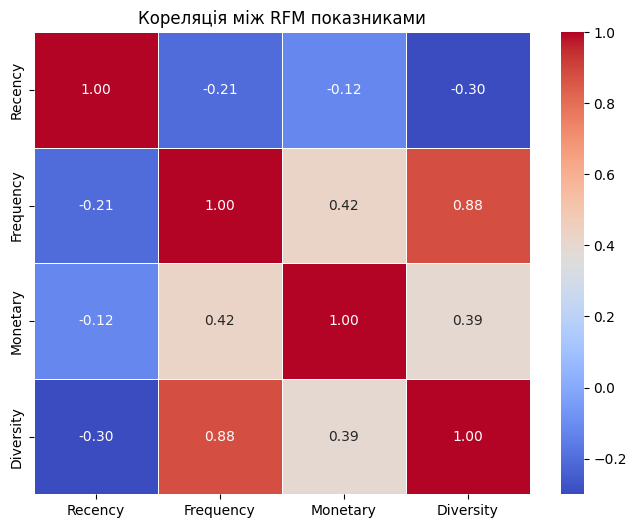

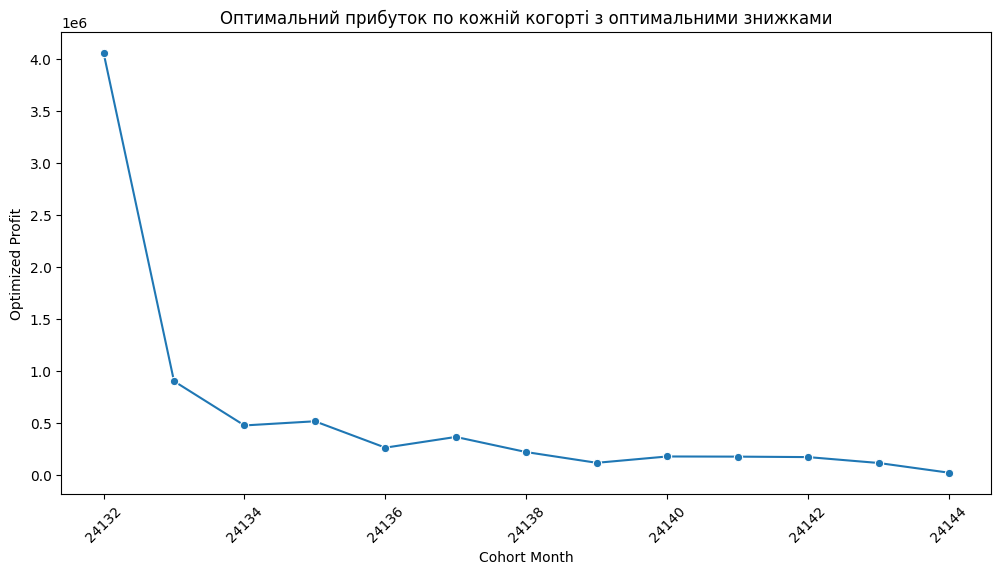

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import files
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from collections import deque
import random

# Завантаження файлу вручну
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Завантаження даних у DataFrame
df = pd.read_excel(file_name)
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df['PurchaseMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortIndex'] = (df['PurchaseMonth'] - df['CohortMonth']).apply(lambda x: x.n)

recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (df['InvoiceDate'].max() - recency['InvoiceDate']).dt.days

frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency.rename(columns={'InvoiceDate': 'Frequency'}, inplace=True)

monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

diversity = df.groupby('CustomerID')['Description'].nunique().reset_index()
diversity.rename(columns={'Description': 'Diversity'}, inplace=True)

rfm = pd.merge(recency[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
rfm = pd.merge(rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')
rfm = pd.merge(rfm, diversity[['CustomerID', 'Diversity']], on='CustomerID')

cohort_data = df.groupby(['CustomerID', 'CohortMonth'])['CohortIndex'].max().reset_index()
rfm = pd.merge(rfm, cohort_data[['CustomerID', 'CohortMonth', 'CohortIndex']], on='CustomerID')
rfm['CohortMonth'] = rfm['CohortMonth'].dt.year * 12 + rfm['CohortMonth'].dt.month

# Агент DQN
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.995, exploration_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.exploration_min = exploration_min
        self.model = self._build_model()

    def _build_model(self):
        # Нейронна мережа для апроксимації Q-функції
        model = Sequential([
            Input(shape=(self.state_size,)),
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.discount_factor * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

# Функція для розрахунку нагороди
def calculate_feedback_reward(row, previous_purchases):
    customer_id = row['CustomerID']
    new_purchases = row['Monetary']
    previous_purchases = previous_purchases.get(customer_id, 0)
    purchase_diff = new_purchases - previous_purchases

    diversity_reward = row['Diversity'] * 0.1

    if purchase_diff > 100:
        return 50 + purchase_diff * 0.2 + diversity_reward
    elif purchase_diff > 0:
        return 20 + purchase_diff * 0.1 + diversity_reward
    elif purchase_diff == 0:
        return 5 + diversity_reward
    else:
        return -10

# Параметри агента
state_size = 4  # Recency, Frequency, Monetary, Diversity
action_size = 6  # Знижки: 0%, 5%, 10%, 15%, 20%, 25%
agent = DQNAgent(state_size, action_size)

# Підготовка даних
rfm_states = rfm[['Recency', 'Frequency', 'Monetary', 'Diversity']].values
scaler = StandardScaler()
rfm_states = scaler.fit_transform(rfm_states)

customer_purchases = df.groupby('CustomerID')['TotalPrice'].sum().to_dict()

# Навчання агента
n_episodes = 50
batch_size = 32

for episode in tqdm(range(n_episodes), desc="Training Episodes"):
    for idx in range(len(rfm)):
        row = rfm.iloc[idx]
        state = np.reshape(rfm_states[idx], [1, state_size])
        action = agent.act(state)
        discount = [0, 5, 10, 15, 20, 25][action]
        adjusted_price = customer_purchases[row['CustomerID']] * (1 - discount / 100)
        reward = calculate_feedback_reward(row, customer_purchases)
        next_state = state  # Для простоти, припустимо, що стан не змінюється
        done = True  # Епізод завершується після одного кроку
        agent.remember(state, action, reward, next_state, done)

    agent.replay(batch_size)

# Застосування політики агента
def apply_discount_policy(row, agent):
    state_idx = row.name
    state = np.reshape(rfm_states[state_idx], [1, state_size])
    action = np.argmax(agent.model.predict(state, verbose=0))
    discount_percentage = [0, 5, 10, 15, 20, 25][action]
    return discount_percentage

rfm['PredictedDiscount'] = rfm.apply(apply_discount_policy, axis=1, agent=agent)

# Розрахунок середнього прибутку за кожну когорту
rfm['AdjustedTotalPrice'] = rfm['Monetary'] * (1 - rfm['PredictedDiscount'] / 100)

# Розрахунок середнього прибутку по кожній когорті
cohort_profit = rfm.groupby('CohortMonth').agg({
    'AdjustedTotalPrice': 'sum'
}).reset_index()

# Розрахунок кореляції між RFM показниками
correlation_matrix = rfm[['Recency', 'Frequency', 'Monetary', 'Diversity']].corr()

# Візуалізація кореляції
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Кореляція між RFM показниками')
plt.show()

# Визначення оптимального рівня дисконту для кожної когорти
optimal_discount_for_cohort = []

for cohort in rfm['CohortMonth'].unique():
    cohort_data = rfm[rfm['CohortMonth'] == cohort]
    cohort_profit = cohort_data.groupby('PredictedDiscount').agg({
        'AdjustedTotalPrice': 'sum'
    }).reset_index()

    # Вибір дисконту, який максимізує прибуток
    optimal_discount = cohort_profit.loc[cohort_profit['AdjustedTotalPrice'].idxmax()]['PredictedDiscount']
    optimal_discount_for_cohort.append((cohort, optimal_discount))

# Перетворення результатів в DataFrame для зручності перегляду
optimal_discount_df = pd.DataFrame(optimal_discount_for_cohort, columns=['CohortMonth', 'OptimalDiscount'])

# Об'єднуємо результати оптимальних знижок з основним DataFrame
rfm = pd.merge(rfm, optimal_discount_df[['CohortMonth', 'OptimalDiscount']], on='CohortMonth', how='left')

# Перерахунок AdjustedTotalPrice з урахуванням оптимальних знижок
rfm['OptimizedAdjustedTotalPrice'] = rfm['Monetary'] * (1 - rfm['OptimalDiscount'] / 100)

# Візуалізація прибутку для кожної когорт
cohort_profit = rfm.groupby('CohortMonth').agg({
    'OptimizedAdjustedTotalPrice': 'sum'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='CohortMonth', y='OptimizedAdjustedTotalPrice', data=cohort_profit, marker='o')
plt.title('Оптимальний прибуток по кожній когорті з оптимальними знижками')
plt.xlabel('Cohort Month')
plt.ylabel('Optimized Profit')
plt.xticks(rotation=45)
plt.show()

# Збереження результатів
with pd.ExcelWriter('rfmd_optimal_discounts.xlsx') as writer:
    rfm.to_excel(writer, sheet_name='RFM and Optimal Discounts', index=False)
    optimal_discount_df.to_excel(writer, sheet_name='Optimal Discounts by Cohort', index=False)

files.download('rfmd_optimal_discounts.xlsx')
